# Installing Python required libraries (When finish the cell will request to restart the runtime, please click on the buton "Restart runtime")

In [1]:
!pip uninstall tensorflow tensorflow-gpu seaborn --yes
!pip install tensorflow-gpu==1.14.0 keras==2.2.5 numpy==1.19.2 seaborn==0.10.1 scipy==1.5.2 scikit-learn==0.23.2 prettytable==1.0.1 wfdb==3.1.1 >> /dev/null

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.14.0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==1.14.0


# Data download from PhysioNet servers. Then extract signals to data folder

In [1]:
! rm -r *
!ls
!wget https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip 
!wget https://physionet.org/static/published-projects/nstdb/mit-bih-noise-stress-test-database-1.0.0.zip
!ls
print('Downloading data: Done')

!mkdir data
!unzip qt-database-1.0.0.zip >> /dev/null
!unzip mit-bih-noise-stress-test-database-1.0.0.zip >> /dev/null
!mv qt-database-1.0.0 data/
!mv mit-bih-noise-stress-test-database-1.0.0 data/
!rm qt-database-1.0.0.zip
!rm mit-bih-noise-stress-test-database-1.0.0.zip
!ls
!ls data
print('Extracting data: Done')

--2024-09-03 23:33:38--  https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87119682 (83M) [application/zip]
Saving to: ‘qt-database-1.0.0.zip’

qt-database-1.0.0.z 100%[===================>]  83.08M   506KB/s    in 3m 5s   

2024-09-03 23:36:44 (459 KB/s) - ‘qt-database-1.0.0.zip’ saved [87119682/87119682]

--2024-09-03 23:36:45--  https://physionet.org/static/published-projects/nstdb/mit-bih-noise-stress-test-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70945297 (68M) [application/zip]
Saving to: ‘mit-bih-noise-stress-test-database-1.0.0.zip’

mit-bih-noise-stres 100%[===================>]  67.66M   365KB/s    in 2m 35s  


# Preprocessing ECG data

In [1]:
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle

QTpath='data/qt-database-1.0.0/'
# Desired sampling frecuency
newFs = 360

# Preprocessing signals
namesPath = glob.glob(QTpath + "/*.dat")

# final list that will contain all signals and beats processed
QTDatabaseSignals = dict()

register_name = None
for i in namesPath:

    # reading signals
    aux = i.split('.dat')
    register_name = aux[0].split('/')[-1]
    signal, fields = wfdb.rdsamp(aux[0])
    qu = len(signal)

    # reading annotations
    ann = wfdb.rdann(aux[0], 'pu1')
    anntype = ann.symbol
    annSamples = ann.sample

    # Obtaining P wave start positions
    Anntype = np.array(anntype)
    idx = Anntype == 'p'
    Pidx = annSamples[idx]
    idxS = Anntype == '('
    Sidx = annSamples[idxS]
    idxR = Anntype == 'N'
    Ridx = annSamples[idxR]

    ind = np.zeros(len(Pidx))

    for j in range(len(Pidx)):
        arr = np.where(Pidx[j] > Sidx)
        arr = arr[0]
        ind[j] = arr[-1]

    ind = ind.astype(np.int64)
    Pstart = Sidx[ind]

    # Shift 40ms before P wave start
    Pstart = Pstart - int(0.04*fields['fs'])

    # Extract first channel
    auxSig = signal[0:qu, 0]

    # Beats separation and removing outliers
    # Beats separation and removal of the vectors that contain more or equal than
    # two beats based on QRS annotations
    beats = list()
    for k in range(len(Pstart)-1):
        remove = (Ridx > Pstart[k]) & (Ridx < Pstart[k+1])
        if np.sum(remove) < 2:
            beats.append(auxSig[Pstart[k]:Pstart[k+1]])

    # Creating the list that will contain each beat per signal
    beatsRe = list()

    # processing each beat
    for k in range(len(beats)):
        # Padding data to avoid edge effects caused by resample
        L = math.ceil(len(beats[k])*newFs/fields['fs'])
        normBeat = list(reversed(beats[k])) + list(beats[k]) + list(reversed(beats[k]))

        # resample beat by beat and saving it
        res = resample_poly(normBeat, newFs, fields['fs'])
        res = res[L-1:2*L-1]
        beatsRe.append(res)

    # storing all beats in each corresponding signal, list of list
    QTDatabaseSignals[register_name] = beatsRe

# Save Data
with open('data/QTDatabase.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(QTDatabaseSignals, output)
print('=========================================================')
print('MIT QT database saved as pickle file')

MIT QT database saved as pickle file


# Preprocessing Noise

In [3]:
# import numpy as np
# import wfdb
# import _pickle as pickle

# NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/bw'
# signals, fields = wfdb.rdsamp(NSTDBPath)

# for key in fields:
#     print(key, fields[key])

# np.save('data/NoiseBWL', signals)
# # Save Data
# with open('data/NoiseBWL.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(signals, output)
# print('=========================================================')
# print('MIT BIH data noise stress test database (NSTDB) saved as pickle')


fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


In [2]:
!ls data/

CombinedNoise.pkl			  qt-database-1.0.0
mit-bih-noise-stress-test-database-1.0.0  QTDatabase.pkl


# DL Datasets pereparation

In [3]:
# import numpy as np
# import _pickle as pickle

# print('Getting the Data ready ... ')

# # The seed is used to ensure the ECG always have the same contamination level
# # this enhance reproducibility
# seed = 1234
# np.random.seed(seed=seed)

# # Load QT Database
# with open('data/QTDatabase.pkl', 'rb') as input:
#     # dict {register_name: beats_list}
#     qtdb = pickle.load(input)

# # Load NSTDB
# with open('data/NoiseBWL.pkl', 'rb') as input:
#     nstd = pickle.load(input)
#     # print(len(nstd)) 3

# #####################################
# # NSTDB
# #####################################

# noise_channel1 = nstd[:, 0]
# noise_channel2 = nstd[:, 1]

# #####################################
# # Data split
# #####################################

# noise_test = np.concatenate(
#     (noise_channel1[0:int(noise_channel1.shape[0] * 0.13)], noise_channel2[0:int(noise_channel2.shape[0] * 0.13)]))
# noise_train = np.concatenate((noise_channel1[int(noise_channel1.shape[0] * 0.13):-1],
#                               noise_channel2[int(noise_channel2.shape[0] * 0.13):-1]))

# #####################################
# # QTDatabase
# #####################################

# beats_train = []
# beats_test = []

# # QTDatabese signals Dataset splitting. Considering the following link
# # https://www.physionet.org/physiobank/database/qtdb/doc/node3.html
# #  Distribution of the 105 records according to the original Database.
# #  | MIT-BIH | MIT-BIH |   MIT-BIH  |  MIT-BIH  | ESC | MIT-BIH | Sudden |
# #  | Arrhyt. |  ST DB  | Sup. Vent. | Long Term | STT | NSR DB	| Death  |
# #  |   15    |   6	   |     13     |     4     | 33  |  10	    |  24    |
# #
# # The two random signals of each pathology will be keep for testing set.
# # The following list was used
# # https://www.physionet.org/physiobank/database/qtdb/doc/node4.html
# # Selected test signal amount (14) represent ~13 % of the total

# test_set = ['sel123',  # Record from MIT-BIH Arrhythmia Database
#             'sel233',  # Record from MIT-BIH Arrhythmia Database

#             'sel302',  # Record from MIT-BIH ST Change Database
#             'sel307',  # Record from MIT-BIH ST Change Database

#             'sel820',  # Record from MIT-BIH Supraventricular Arrhythmia Database
#             'sel853',  # Record from MIT-BIH Supraventricular Arrhythmia Database

#             'sel16420',  # Record from MIT-BIH Normal Sinus Rhythm Database
#             'sel16795',  # Record from MIT-BIH Normal Sinus Rhythm Database

#             'sele0106',  # Record from European ST-T Database
#             'sele0121',  # Record from European ST-T Database

#             'sel32',  # Record from ``sudden death'' patients from BIH
#             'sel49',  # Record from ``sudden death'' patients from BIH

#             'sel14046',  # Record from MIT-BIH Long-Term ECG Database
#             'sel15814',  # Record from MIT-BIH Long-Term ECG Database
#             ]

# # Creating the train and test dataset, each datapoint has 512 samples and is zero padded
# # beats bigger that 512 samples are discarded to avoid wrong split beats ans to reduce
# # computation.
# skip_beats = 0
# samples = 512
# qtdb_keys = list(qtdb.keys())
# # print(len(qtdb_keys))
# # 105
# for i in range(len(qtdb_keys)):
#     signal_name = qtdb_keys[i]
# #     print(signal_name)sele0122
# # sele0107
# # sel16272
# # sele0604...
# #     print(np.array(qtdb[signal_name]).shape) (1412,) 각 select에 대한 beat의 갯수
# # (808,)
# # (838,)
# # (1024,)
# # (182,)
# # (743,)....
#     for b in qtdb[signal_name]:
#         b_np = np.zeros(samples)
#         b_sq = np.array(b)
#         # There are beats with more than 512 samples (could be up to 3500 samples)
#         # Creating a threshold of 512 - init_padding samples max. gives a good compromise between
#         # the samples amount and the discarded signals amount
#         # before:
#         # train: 74448  test: 13362
#         # after:
#         # train: 71893 test: 13306  (discarded train: ~4k datapoints test: ~50)

#         init_padding = 16
#         if b_sq.shape[0] > (samples - init_padding):
#             skip_beats += 1
#             continue

#         b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

#         if signal_name in test_set:
#             beats_test.append(b_np)
#         else:
#             beats_train.append(b_np)

# # Noise was added in a proportion from 0.2 to 2 times the ECG signal amplitude
# # Similar to
# # W. Muldrow, R.G. Mark, & Moody, G. B. (1984).
# # A noise stress test for arrhythmia detectors.
# # Computers in Cardiology, 381–384

# sn_train = []
# sn_test = []

# noise_index = 0

# # Adding noise to train
# rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
# for i in range(len(beats_train)):
#     noise = noise_train[noise_index:noise_index + samples]
#     beat_max_value = np.max(beats_train[i]) - np.min(beats_train[i])
#     noise_max_value = np.max(noise) - np.min(noise)
#     Ase = noise_max_value / beat_max_value
#     alpha = rnd_train[i] / Ase
#     signal_noise = beats_train[i] + alpha * noise
#     sn_train.append(signal_noise)
#     noise_index += samples

#     if noise_index > (len(noise_train) - samples):
#         noise_index = 0

# # Adding noise to test
# noise_index = 0
# rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
# for i in range(len(beats_test)):
#     noise = noise_test[noise_index:noise_index + samples]
#     beat_max_value = np.max(beats_test[i]) - np.min(beats_test[i])
#     noise_max_value = np.max(noise) - np.min(noise)
#     Ase = noise_max_value / beat_max_value
#     alpha = rnd_test[i] / Ase
#     signal_noise = beats_test[i] + alpha * noise
#     sn_test.append(signal_noise)
#     noise_index += samples

#     if noise_index > (len(noise_test) - samples):
#         noise_index = 0

# X_train = np.array(sn_train)
# y_train = np.array(beats_train)

# X_test = np.array(sn_test)
# y_test = np.array(beats_test)

# X_train = np.expand_dims(X_train, axis=2)
# y_train = np.expand_dims(y_train, axis=2)

# X_test = np.expand_dims(X_test, axis=2)
# y_test = np.expand_dims(y_test, axis=2)

# Dataset = [X_train, y_train, X_test, y_test]

# print('Dataset ready to use.')

In [1]:
import numpy as np
import wfdb
import _pickle as pickle

# Prepare NSTDB data (baseline wander, electrode motion, muscle artifact)
def prepare_nstdb_data(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    bw_signals, bw_fields = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, em_fields = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, ma_fields = wfdb.rdsamp(NSTDBPath + 'ma')
    print(f"[INFO] Loaded baseline wander (bw) signals: shape {bw_signals.shape}")
    print(f"[INFO] Loaded electrode motion (em) signals: shape {em_signals.shape}")
    print(f"[INFO] Loaded muscle artifact (ma) signals: shape {ma_signals.shape}")
    
    # Save Data
    with open('data/NoiseBWL.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump([bw_signals, em_signals, ma_signals], output)
    print('=========================================================')
    print('MIT BIH data noise stress test database (NSTDB) saved as pickle')


In [2]:
import pickle
import numpy as np

# 파일 경로
file_path = '/home/dhc99/DeepFilter_as_in_Arxiv/data/QTDatabase.pkl'

# 파일 로드
with open(file_path, 'rb') as file:
    qtdb = pickle.load(file)

# 데이터 구조 확인
print(f"Type of qtdb: {type(qtdb)}")

# 만약 qtdb가 딕셔너리라면, 각 키와 그 데이터의 shape을 확인
if isinstance(qtdb, dict):
    for key, value in qtdb.items():
        print(f"Key: {key}")
        
        # 각 항목의 shape 확인 (넘파이 배열이 아니면 리스트의 길이 출력)
        if isinstance(value, list):
            print(f"Number of beats in {key}: {len(value)}")
            if len(value) > 0:
                print(f"Shape of first beat in {key}: {np.array(value[0]).shape}")
        elif isinstance(value, np.ndarray):
            print(f"Shape of {key}: {value.shape}")
        else:
            print(f"Type of value for {key}: {type(value)}")

# 여기서는 첫 번째 beat에 대해 shape을 확인하고, 필요에 따라 추가적인 shape 정보를 출력할 수 있습니다.


Type of qtdb: <class 'dict'>
Key: sele0122
Number of beats in sele0122: 1412
Shape of first beat in sele0122: (228,)
Key: sele0107
Number of beats in sele0107: 808
Shape of first beat in sele0107: (376,)
Key: sel16272
Number of beats in sel16272: 838
Shape of first beat in sel16272: (384,)
Key: sele0604
Number of beats in sele0604: 1024
Shape of first beat in sele0604: (329,)
Key: sel104
Number of beats in sel104: 182
Shape of first beat in sel104: (329,)
Key: sel232
Number of beats in sel232: 743
Shape of first beat in sel232: (260,)
Key: sel16539
Number of beats in sel16539: 911
Shape of first beat in sel16539: (312,)
Key: sel33
Number of beats in sel33: 522
Shape of first beat in sel33: (611,)
Key: sele0606
Number of beats in sele0606: 1328
Shape of first beat in sele0606: (199,)
Key: sel32
Number of beats in sel32: 978
Shape of first beat in sel32: (280,)
Key: sel871
Number of beats in sel871: 900
Shape of first beat in sel871: (362,)
Key: sel39
Number of beats in sel39: 1091
Shape

In [4]:
# import wfdb
# import numpy as np
# import pickle

# def prepare(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', snr_range=(-6, 18)):
#     """
#     Prepares noise data from the MIT-BIH Noise Stress Test Database (NSTDB) with noise combinations as per the TCDAE study.
#     Noise combinations include Baseline Wander (BW), Electrode Motion (EM), and Muscle Artifact (MA) noises.

#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     snr_range: Tuple indicating the SNR range (default: (-6, 18)).
#     """
#     # Load NSTDB (Baseline Wander, Electrode Motion, and Muscle Artifact noises)
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

#     print(f"[INFO] Loaded baseline wander (BW) signals: shape {bw_signals.shape}")
#     print(f"[INFO] Loaded electrode motion (EM) signals: shape {em_signals.shape}")
#     print(f"[INFO] Loaded muscle artifact (MA) signals: shape {ma_signals.shape}")
# # [INFO] Loaded baseline wander (BW) signals: shape (650000, 2)
# # [INFO] Loaded electrode motion (EM) signals: shape (650000, 2)
# # [INFO] Loaded muscle artifact (MA) signals: shape (650000, 2)
#     # Initialize combined noise storage for pickle output
#     combined_noise = []

#     # Loop through both training and test noise channels
#     for channel in range(2):
#         # Get noise data for the current channel (both BW, EM, MA)
#         bw_noise = bw_signals[:, channel]
#         em_noise = em_signals[:, channel]
#         ma_noise = ma_signals[:, channel]
        
#         print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {em_noise.shape}, MA noise shape: {ma_noise.shape}")
#         # 650000, 650000, 650000
#         # Noise combination types based on Fig. 2 in the TCDAE paper (8 combinations of BW, EM, and MA)
#         noise_combinations = [
#             (0, 0, 0),  # Type 1: No noise
#             (1, 0, 0),  # Type 2: BW only
#             (0, 1, 0),  # Type 3: EM only
#             (0, 0, 1),  # Type 4: MA only
#             (1, 1, 0),  # Type 5: BW + EM
#             (1, 0, 1),  # Type 6: BW + MA
#             (0, 1, 1),  # Type 7: EM + MA
#             (1, 1, 1)   # Type 8: BW + EM + MA (all noises)
#         ]

#         # Create a noise matrix to store all possible combinations of noises
#         noise_matrix = np.zeros((bw_noise.shape[0], len(noise_combinations)))
#         print(f"[DEBUG] Initialized noise matrix with shape {noise_matrix.shape}")
#         # 650000, 8
#         # Iterate over all noise combinations to fill the noise matrix
#         for idx, (bw_flag, em_flag, ma_flag) in enumerate(noise_combinations):
#             combined_noise_for_type = (
#                 bw_flag * bw_noise +
#                 em_flag * em_noise +
#                 ma_flag * ma_noise
#             )
#             noise_matrix[:, idx] = combined_noise_for_type
#             print(f"[DEBUG] Filled noise matrix for combination type {idx+1}, shape: {noise_matrix[:, idx].shape}")
#             #650000
#         # Append the noise matrix for this channel to the combined noise list
#         combined_noise.append(noise_matrix)
#         print(f"[INFO] Combined noise for channel {channel+1} has shape {noise_matrix.shape}")
#         # 650000,8
#     # Save combined noise (BW, EM, MA, and their combinations) as a pickle file
#     with open('data/CombinedNoise.pkl', 'wb') as output:  # Overwrites any existing file
#         pickle.dump(combined_noise, output)
#     # print(f'combined noise shape : {np.array(combined_noise).shape}')
#     # combined noise shape : (2, 650000, 8)
#     print('=========================================================')
#     print('MIT BIH data noise stress test database (NSTDB) with combined noise saved as pickle')
# # 채널마다 650000개의 데이터가 있고, 8가지의 노이즈 조합이 있음을 확인할 수 있습니다.


In [8]:
import wfdb
import numpy as np
import pickle

def prepare(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Prepares noise data from the MIT-BIH Noise Stress Test Database (NSTDB) with noise combinations as per the TCDAE study.
    Noise combinations include Baseline Wander (BW), Electrode Motion (EM), and Muscle Artifact (MA) noises.

    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    snr_range: Tuple indicating the SNR range (default: (-6, 18)).
    """
    # Load NSTDB (Baseline Wander, Electrode Motion, and Muscle Artifact noises)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

    # print(f"[INFO] Loaded baseline wander (BW) signals: shape {bw_signals.shape}")
    # print(f"[INFO] Loaded electrode motion (EM) signals: shape {em_signals.shape}")
    # print(f"[INFO] Loaded muscle artifact (MA) signals: shape {ma_signals.shape}")
# [INFO] Loaded baseline wander (BW) signals: shape (650000, 2)
# [INFO] Loaded electrode motion (EM) signals: shape (650000, 2)
# [INFO] Loaded muscle artifact (MA) signals: shape (650000, 2)
    # Initialize combined noise storage for pickle output
    combined_noise = []

    # Loop through both training and test noise channels
    for channel in range(2):
        # Get noise data for the current channel (both BW, EM, MA)
        bw_noise = bw_signals[:, channel]
        em_noise = em_signals[:, channel]
        ma_noise = ma_signals[:, channel]
        
        print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {em_noise.shape}, MA noise shape: {ma_noise.shape}")
        # 650000, 650000, 650000
        # Noise combination types based on Fig. 2 in the TCDAE paper (8 combinations of BW, EM, and MA)
        noise_combinations = [
            (0, 0, 0),  # Type 1: No noise
            (1, 0, 0),  # Type 2: BW only
            (0, 1, 0),  # Type 3: EM only
            (0, 0, 1),  # Type 4: MA only
            (1, 1, 0),  # Type 5: BW + EM
            (1, 0, 1),  # Type 6: BW + MA
            (0, 1, 1),  # Type 7: EM + MA
            (1, 1, 1)   # Type 8: BW + EM + MA (all noises)
        ]

        # Create a noise matrix to store all possible combinations of noises
        noise_matrix = np.zeros((bw_noise.shape[0], len(noise_combinations)))
        print(f"[DEBUG] Initialized noise matrix with shape {noise_matrix.shape}")
        # 650000, 8
        # Iterate over all noise combinations to fill the noise matrix
        for idx, (bw_flag, em_flag, ma_flag) in enumerate(noise_combinations):
            combined_noise_for_type = (
                bw_flag * bw_noise +
                em_flag * em_noise +
                ma_flag * ma_noise
            )
            noise_matrix[:, idx] = combined_noise_for_type
            # print(f"[DEBUG] Filled noise matrix for combination type {idx+1}, shape: {noise_matrix[:, idx].shape}")
            #650000
        # Append the noise matrix for this channel to the combined noise list
        combined_noise.append(noise_matrix)
        # print(f"[INFO] Combined noise for channel {channel+1} has shape {noise_matrix.shape}")
        # 650000,8
    # Save combined noise (BW, EM, MA, and their combinations) as a pickle file
    with open('data/CombinedNoise.pkl', 'wb') as output:  # Overwrites any existing file
        pickle.dump(combined_noise, output)
    # print(f'combined noise shape : {np.array(combined_noise).shape}')
    # combined noise shape : (2, 650000, 8)
    print('=========================================================')
    print('MIT BIH data noise stress test database (NSTDB) with combined noise saved as pickle')
# 채널마다 650000개의 데이터가 있고, 8가지의 노이즈 조합이 있음을 확인할 수 있습니다.


In [ ]:
# def add_noise_to_ecg(beats, combined_noise, samples=512):
#     """
#     Adds noise to ECG signals using a random combination of noise types and random SNR.
#     Handles potential issues such as NaN, infinite values, and invalid noise levels.
    
#     Parameters:
#     beats: List of ECG beats
#     combined_noise: Preloaded noise matrix from the NSTDB (combined_noise.pkl)
#     snr_range: Tuple indicating the SNR range (default: (-6, 18))
#     samples: Number of samples per beat

#     Returns:
#     Noisy ECG beats and valid indices
#     """
#     sn_ecg = []
#     valid_indices = []  # To track which beats have valid noisy versions
#     noise_index = 0

#     print(f"[INFO] Adding noise to ECG beats, total beats: {len(beats)}, samples per beat: {samples}")
    
#     for beat_idx, beat in enumerate(beats):
#         # if len(beat) == 0:
#         #     print(f"[WARNING] Empty beat detected, skipping.")
#         #     continue
# #0~8 로 하면 noise_max_value가 0이 되어서 alpha가 0이 되어버림
#         noise_combination_idx = np.random.randint(1, 8)  # 8 types of noise combinations
#         noise = combined_noise[:, noise_combination_idx]
#         # print(f'noise shape : {noise.shape}') 650000
#         noise_segment = noise[noise_index:noise_index + samples]

#         # if len(noise_segment) == 0:
#         #     print(f"[WARNING] Noise segment is empty, skipping.")
#         #     continue

#         # Apply random SNR
#         rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
#         rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
#         beat_max_value = np.max(beat) - np.min(beat)
#         noise_max_value = np.max(noise_segment) - np.min(noise_segment)

#         # if noise_max_value == 0 or beat_max_value == 0:
#         #     print(f'noise_max_value: {noise_max_value}, beat_max_value: {beat_max_value}')
#         #     print(f"[WARNING] Zero max values detected in beat or noise, skipping.")
#         #     continue

#         Ase = noise_max_value / beat_max_value
#         alpha = snr / Ase


#         # Add noise to ECG beat
#         signal_noise = beat + alpha * noise_segment

#         # # Ensure no NaN or infinity values are present
#         # if np.any(np.isnan(signal_noise)) or np.any(np.isinf(signal_noise)):
#         #     print(f"[WARNING] Invalid noisy signal detected (NaN or Inf), skipping.")
#         #     continue

#         sn_ecg.append(signal_noise)
#         valid_indices.append(beat_idx)  # Only track valid beats
#         print(f"[DEBUG] Processed beat {beat_idx} with shape: {beat.shape}, noise shape: {noise_segment.shape}, alpha: {alpha}")

#         noise_index += samples
#         if noise_index > (len(noise) - samples):
#             noise_index = 0
#             print(f"[INFO] Resetting noise index to 0, noise length exceeded {len(noise)}")

#     return np.array(sn_ecg), valid_indices


In [1]:
# def add_noise_to_ecg(beats, combined_noise, snr_range=(-6, 18), samples=512):
#     """
#     Adds noise to ECG signals using a random combination of noise types and random SNR.
#     Handles potential issues such as NaN, infinite values, and invalid noise levels.
    
#     Parameters:
#     beats: List of ECG beats
#     combined_noise: Preloaded noise matrix from the NSTDB (combined_noise.pkl)
#     snr_range: Tuple indicating the SNR range (default: (-6, 18))
#     samples: Number of samples per beat

#     Returns:
#     Noisy ECG beats and valid indices
#     """
#     sn_ecg = []
#     valid_indices = []  # To track which beats have valid noisy versions
#     noise_index = 0

#     print(f"[INFO] Adding noise to ECG beats, total beats: {len(beats)}, samples per beat: {samples}")
    
#     for beat_idx, beat in enumerate(beats):
#         # if len(beat) == 0:
#         #     print(f"[WARNING] Empty beat detected, skipping.")
#         #     continue
# #0~8 로 하면 noise_max_value가 0이 되어서 alpha가 0이 되어버림
#         noise_combination_idx = np.random.randint(1, 8)  # 8 types of noise combinations
#         noise = combined_noise[:, noise_combination_idx]
#         # print(f'noise shape : {noise.shape}') 650000
#         noise_segment = noise[noise_index:noise_index + samples]

#         # if len(noise_segment) == 0:
#         #     print(f"[WARNING] Noise segment is empty, skipping.")
#         #     continue

#         # Apply random SNR
#         snr = np.random.randint(*snr_range)
#         beat_max_value = np.max(beat) - np.min(beat)
#         noise_max_value = np.max(noise_segment) - np.min(noise_segment)

#         # if noise_max_value == 0 or beat_max_value == 0:
#         #     print(f'noise_max_value: {noise_max_value}, beat_max_value: {beat_max_value}')
#         #     print(f"[WARNING] Zero max values detected in beat or noise, skipping.")
#         #     continue

#         Ase = noise_max_value / beat_max_value
#         alpha = snr / Ase


#         # Add noise to ECG beat
#         signal_noise = beat + alpha * noise_segment

#         # # Ensure no NaN or infinity values are present
#         # if np.any(np.isnan(signal_noise)) or np.any(np.isinf(signal_noise)):
#         #     print(f"[WARNING] Invalid noisy signal detected (NaN or Inf), skipping.")
#         #     continue

#         sn_ecg.append(signal_noise)
#         valid_indices.append(beat_idx)  # Only track valid beats
#         print(f"[DEBUG] Processed beat {beat_idx} with shape: {beat.shape}, noise shape: {noise_segment.shape}, alpha: {alpha}")

#         noise_index += samples
#         if noise_index > (len(noise) - samples):
#             noise_index = 0
#             print(f"[INFO] Resetting noise index to 0, noise length exceeded {len(noise)}")

#     return np.array(sn_ecg), valid_indices


In [14]:
def Data_Preparation(samples,channel_ratio):
    print('Getting the Data ready ...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)

    # Load QT Database
    with open('data/QTDatabase.pkl', 'rb') as input:
        qtdb = pickle.load(input)

    print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")

    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split
    #####################################
    test_set = ['sel123', 'sel233', 'sel302', 'sel307', 'sel820', 'sel853', 
                'sel16420', 'sel16795', 'sele0106', 'sele0121', 'sel32', 'sel49', 
                'sel14046', 'sel15814']

    beats_train = []
    beats_test = []
    valid_train_indices = []  # To keep track of valid indices in training data
    valid_test_indices = []   # To keep track of valid indices in test data
    sn_train = []
    sn_test = []
    
    skip_beats = 0
    # samples = 512
    qtdb_keys = list(qtdb.keys())

    print(f"[INFO] Processing QTDatabase, {len(qtdb_keys)} signals to process.")

    for signal_name in qtdb_keys:
        for b_idx, b in enumerate(qtdb[signal_name]):
            b_np = np.zeros(samples)
            b_sq = np.array(b)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):
                skip_beats += 1
                continue
# 이 평균값을 b_sq의 각 값에서 빼는 과정은 신호의 중앙화 작업입니다. 즉, 신호의 값들이 배열의 양 끝 값의 평균을 기준으로 대칭적으로 배치되도록 변환됩니다.
# 이 계산을 통해 신호의 첫 값과 마지막 값에 대한 편향을 제거하고, 신호를 중앙으로 이동시키는 효과가 있습니다.
            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            if signal_name in test_set:
                beats_test.append(b_np)
                valid_test_indices.append(len(beats_test) - 1)  # Track valid test beat index
            else:
                beats_train.append(b_np)
                valid_train_indices.append(len(beats_train) - 1)  # Track valid train beat index

        print(f"[DEBUG] Processed signal {signal_name}, total beats in train: {len(beats_train)}, total beats in test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")
    # Random scaling factor for train and test
    rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
    noise_index = 0
    # Adding noise to train
    for beat_idx, beat in enumerate(beats_train):
        if np.random.rand() < channel_ratio:
            noise_combination_idx = np.random.randint(1, 8)  # 8 types of noise combinations
            noise = combined_noise[0][:, noise_combination_idx]
            noise_segment = noise[noise_index:noise_index + samples]
            beat_max_value = np.max(beat) - np.min(beat)
            noise_max_value = np.max(noise_segment) - np.min(noise_segment)
            Ase = noise_max_value / beat_max_value
            alpha = rnd_train[beat_idx] / Ase
            signal_noise = beat + alpha * noise_segment
            sn_train.append(signal_noise)
            noise_index += samples
            if noise_index > (len(noise) - samples):
                noise_index = 0
            valid_train_indices.append(beat_idx)  # Only track valid beats
        else :
            noise_combination_idx = np.random.randint(1, 8)  # 8 types of noise combinations
            noise = combined_noise[1][:, noise_combination_idx]
            noise_segment = noise[noise_index:noise_index + samples]
            beat_max_value = np.max(beat) - np.min(beat)
            noise_max_value = np.max(noise_segment) - np.min(noise_segment)
            Ase = noise_max_value / beat_max_value
            alpha = rnd_train[beat_idx] / Ase
            signal_noise = beat + alpha * noise_segment
            sn_train.append(signal_noise)
            noise_index += samples
            if noise_index > (len(noise) - samples):
                noise_index = 0
            valid_train_indices.append(beat_idx)  # Only track valid beats
                
    # Adding noise to test
    noise_index = 0
    rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
    # Saving the random array so we can use it on the amplitude segmentation tables
    np.save('rnd_test.npy', rnd_test)
    print('rnd_test shape: ' + str(rnd_test.shape))
    
    for beat_idx, beat in enumerate(beats_test):
        if np.random.rand() < channel_ratio:
            noise_combination_idx = np.random.randint(1, 8)  # 8 types of noise combinations
            noise = combined_noise[0][:, noise_combination_idx]
            noise_segment = noise[noise_index:noise_index + samples]
            beat_max_value = np.max(beat) - np.min(beat)
            noise_max_value = np.max(noise_segment) - np.min(noise_segment)
            Ase = noise_max_value / beat_max_value
            alpha = rnd_test[beat_idx] / Ase
            signal_noise = beat + alpha * noise_segment
            sn_test.append(signal_noise)
            noise_index += samples
            if noise_index > (len(noise) - samples):
                noise_index = 0
            valid_test_indices.append(beat_idx)  # Only track valid beats
        else :
            noise_combination_idx = np.random.randint(1, 8)  # 8 types of noise combinations
            noise = combined_noise[1][:, noise_combination_idx]
            noise_segment = noise[noise_index:noise_index + samples]
            beat_max_value = np.max(beat) - np.min(beat)
            noise_max_value = np.max(noise_segment) - np.min(noise_segment)
            Ase = noise_max_value / beat_max_value
            alpha = rnd_test[beat_idx] / Ase
            signal_noise = beat + alpha * noise_segment
            sn_test.append(signal_noise)
            noise_index += samples
            if noise_index > (len(noise) - samples):
                noise_index = 0
            valid_test_indices.append(beat_idx)  # Only track valid beats
    

    X_train = np.array(sn_train)[valid_train_indices]  # Match noisy and original beats
    X_test = np.array(sn_test)[valid_test_indices]

    y_train = np.array(beats_train)[valid_train_indices]  # Match noisy and original beats
    y_test = np.array(beats_test)[valid_test_indices]

    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    Dataset = [X_train, y_train, X_test, y_test]
    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print('Dataset ready to use.')

    return Dataset, valid_train_indices, valid_test_indices


In [15]:
# prepare() 함수 실행
prepare(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')
# Data_Preparation 함수 실행
# Call Data_Preparation and capture the return values
Dataset, valid_train_indices, valid_test_indices = Data_Preparation(samples=512, channel_ratio=0.5)

# Unpack the dataset
X_train, y_train, X_test, y_test = Dataset

# Now you can check the dataset contents and the valid indices
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Check valid indices for train and test sets
print(f"Number of valid train beats: {len(valid_train_indices)}")
print(f"Number of valid test beats: {len(valid_test_indices)}")

[DEBUG] Processing channel 1: BW noise shape: (650000,), EM noise shape: (650000,), MA noise shape: (650000,)
[DEBUG] Initialized noise matrix with shape (650000, 8)
[DEBUG] Processing channel 2: BW noise shape: (650000,), EM noise shape: (650000,), MA noise shape: (650000,)
[DEBUG] Initialized noise matrix with shape (650000, 8)
MIT BIH data noise stress test database (NSTDB) with combined noise saved as pickle
Getting the Data ready ...
[INFO] Loaded QTDatabase with 105 signals
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Processing QTDatabase, 105 signals to process.
[DEBUG] Processed signal sele0122, total beats in train: 1412, total beats in test: 0
[DEBUG] Processed signal sele0107, total beats in train: 2220, total beats in test: 0
[DEBUG] Processed signal sel16272, total beats in train: 3058, total beats in test: 0
[DEBUG] Processed signal sele0604, total beats in train: 4082, total beats in test: 0
[DEBUG] Processed signal sel104, total beats in train: 4264, total beats 

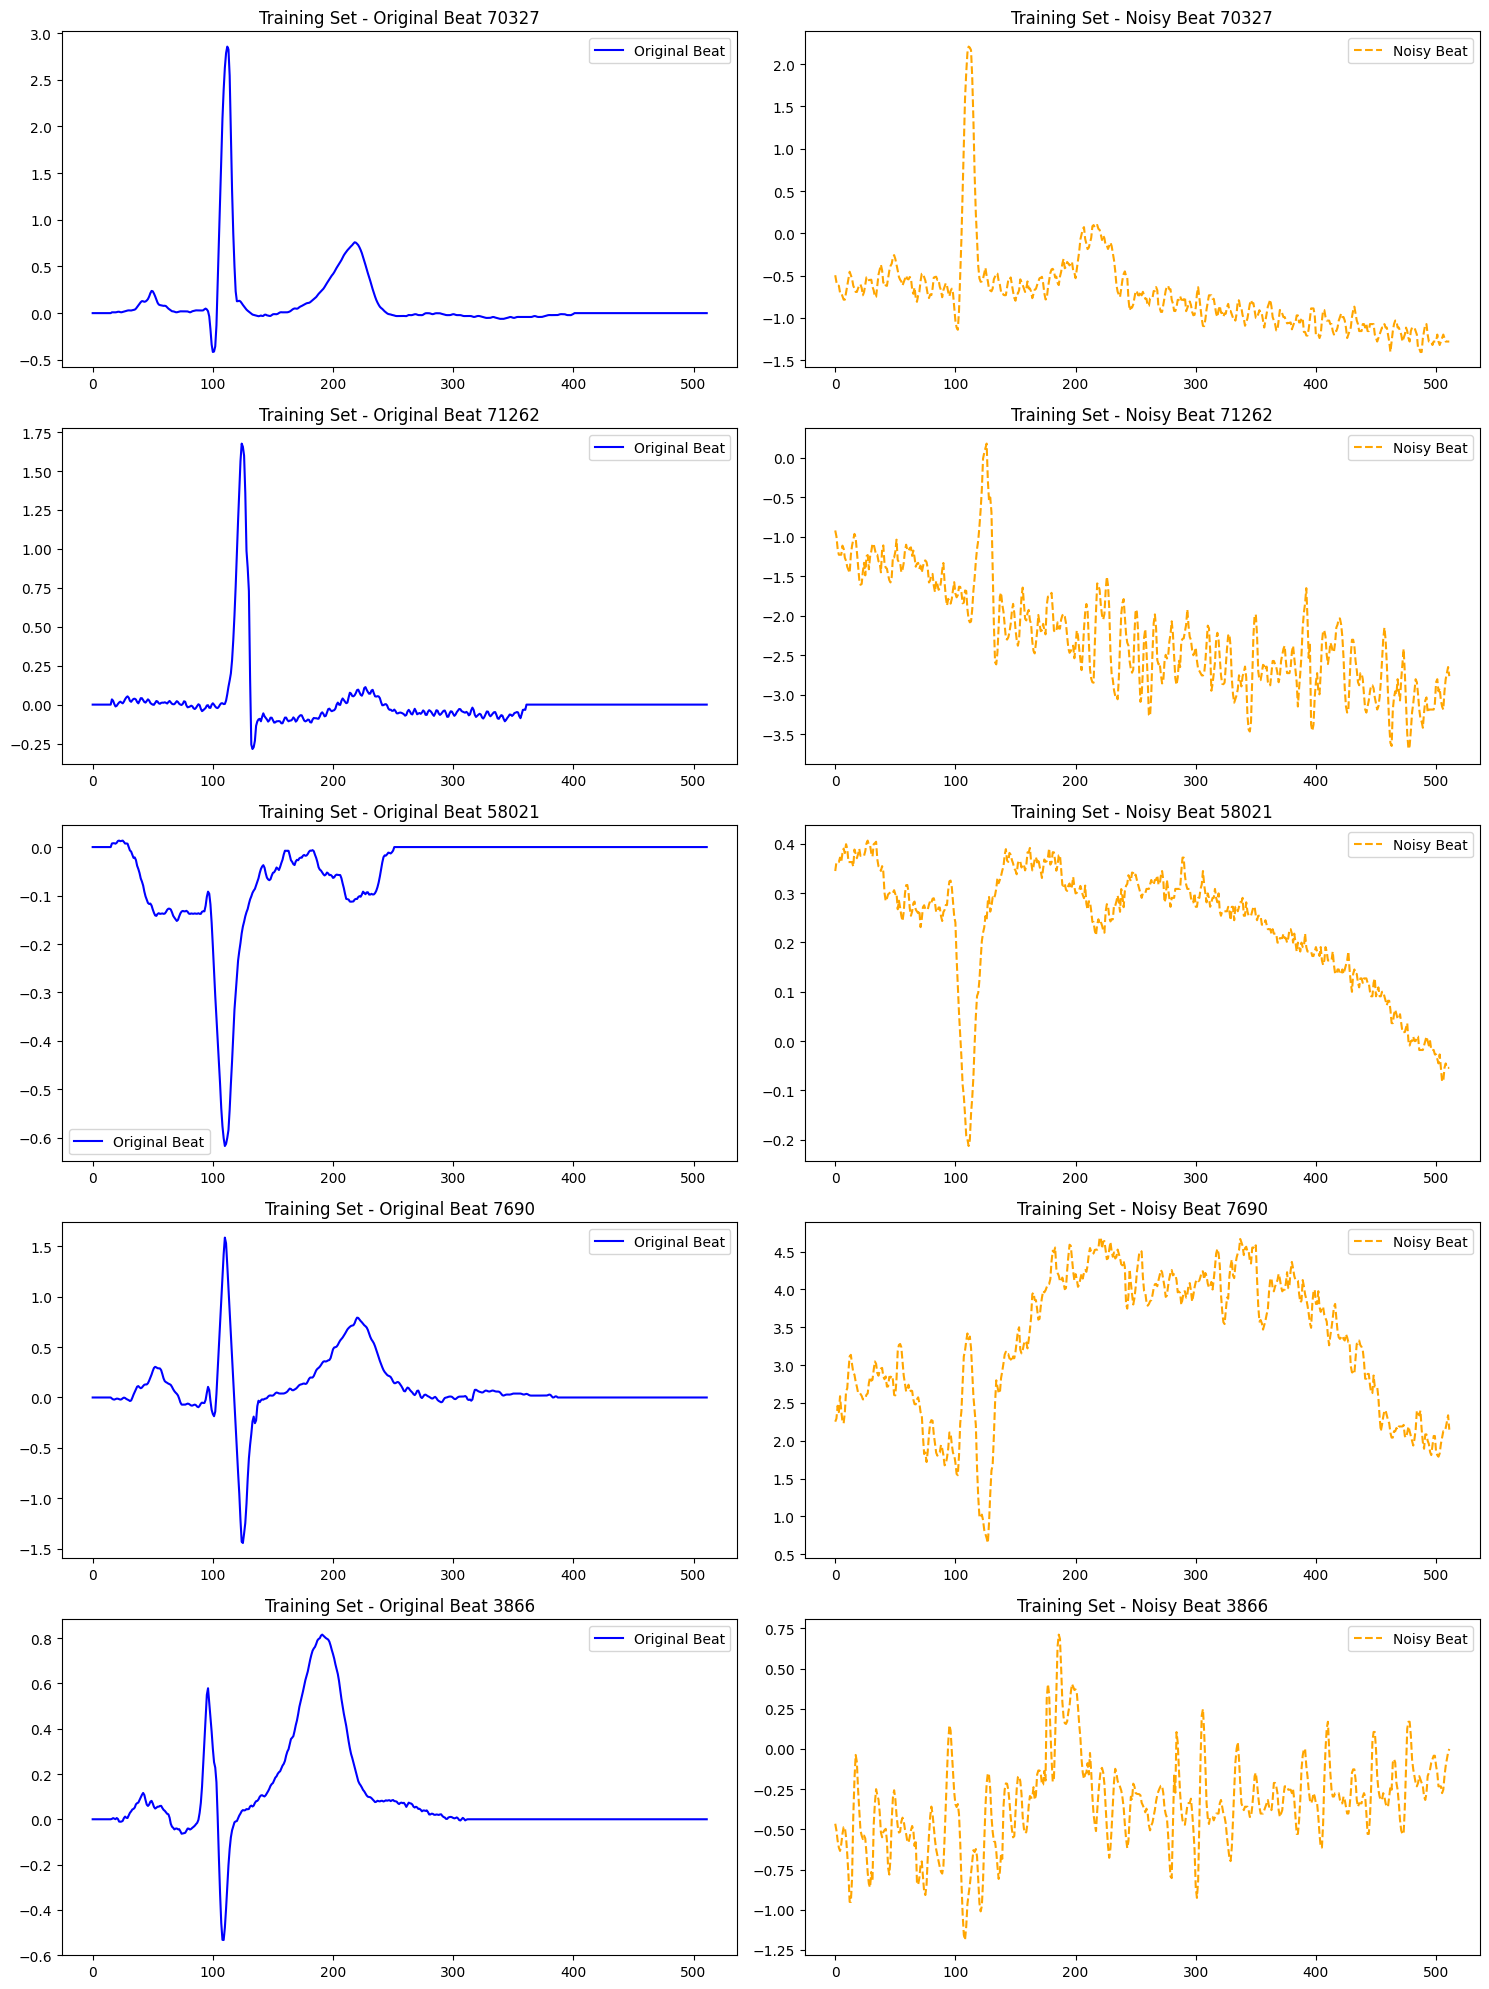

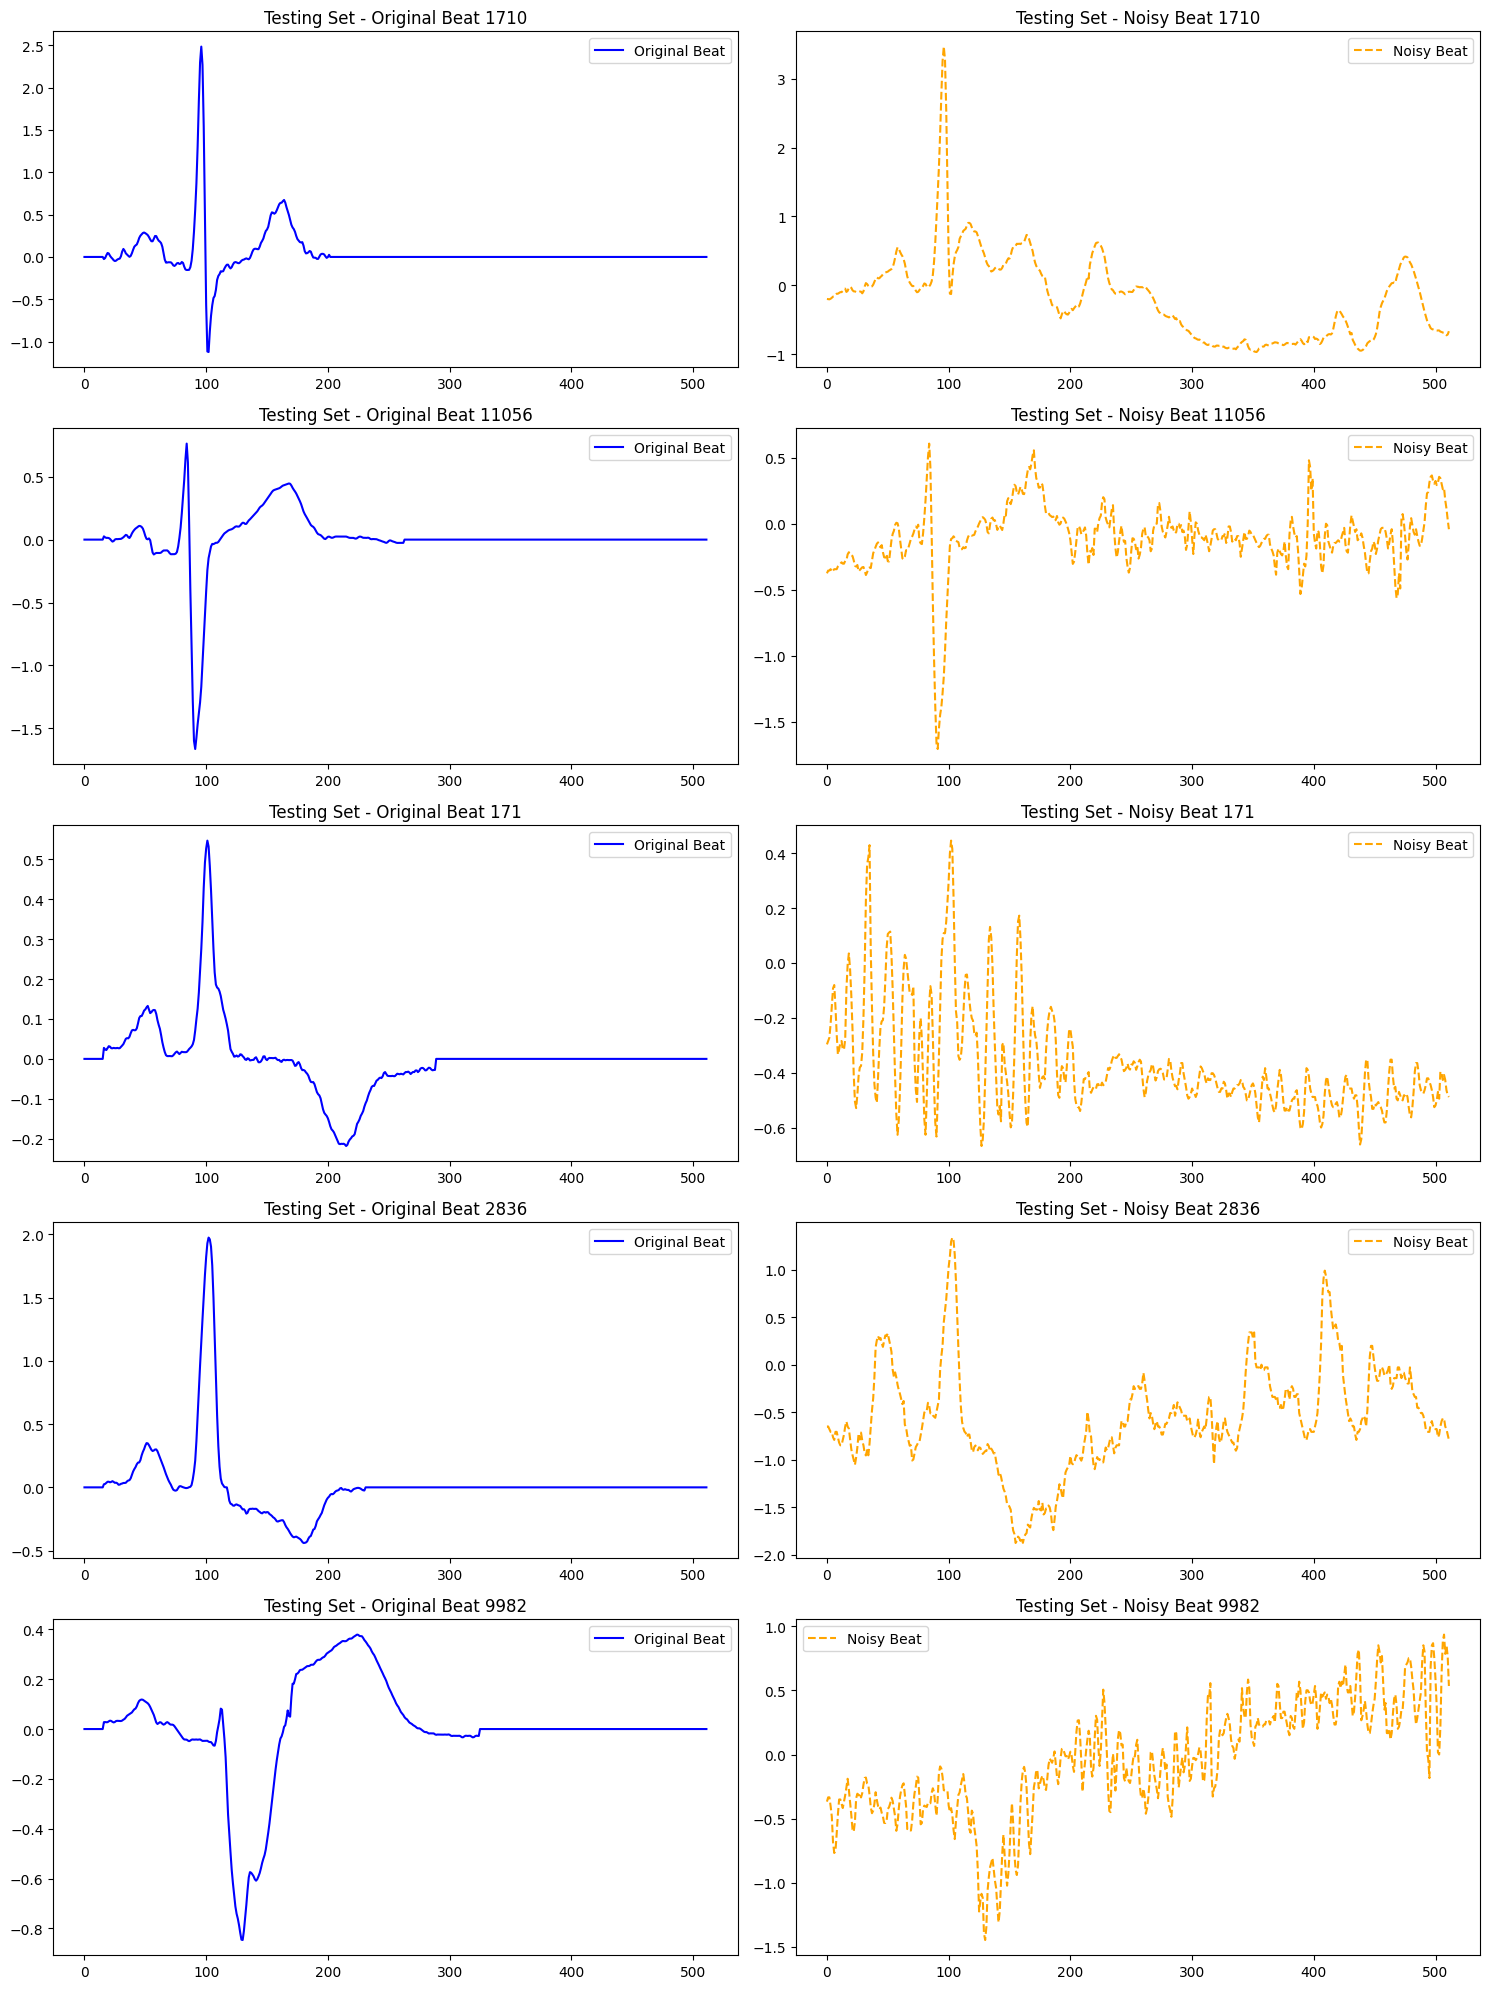

In [16]:
import matplotlib.pyplot as plt
import random

# Function to visualize original and noisy beats separately
def plot_ecg_comparison_separate(X_data, y_data, indices, title, num_beats=5):
    """
    Visualizes the original and noisy ECG beats separately.
    
    Parameters:
    X_data: Noisy ECG beats (X_train or X_test)
    y_data: Original ECG beats (y_train or y_test)
    indices: Valid indices for the beats
    title: Title for the plot
    num_beats: Number of beats to visualize
    """
    # Randomly select a subset of valid indices for visualization
    if len(indices) < num_beats:
        num_beats = len(indices)  # Ensure we don't sample more than available valid beats
    selected_indices = random.sample(indices, num_beats)

    plt.figure(figsize=(15, num_beats * 4))

    for i, idx in enumerate(selected_indices):
        # Original beat plot
        plt.subplot(num_beats, 2, 2*i + 1)
        plt.plot(y_data[idx], label="Original Beat", color="blue")
        plt.title(f"{title} - Original Beat {idx}")
        plt.legend()

        # Noisy beat plot
        plt.subplot(num_beats, 2, 2*i + 2)
        plt.plot(X_data[idx], label="Noisy Beat", color="orange", linestyle="--")
        plt.title(f"{title} - Noisy Beat {idx}")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the comparison for training data
plot_ecg_comparison_separate(X_train, y_train, valid_train_indices, "Training Set", num_beats=5)

# Visualize the comparison for testing data
plot_ecg_comparison_separate(X_test, y_test, valid_test_indices, "Testing Set", num_beats=5)


# Define Metric functions

In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension


def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension


def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD


def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

# Visualization functions

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Method/Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    # Print tabular results in the console, in a pretty way

    # The FIR and IIR are the last on all_values
    # We need circular shift them to the right
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')

def generate_hboxplot(np_data, description, ylabel, log, set_x_axis_size=None):
    # Process the results and store in Panda objects
    col = description
    loss_val_np = np.rot90(np_data)

    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    sns.set(style="whitegrid")

    f, ax = plt.subplots(figsize=(15, 6))

    ax = sns.boxplot(data=pd_df, orient="h", width=0.4)

    if log:
        ax.set_xscale("log")

    if set_x_axis_size != None:
        ax.set_xlim(set_x_axis_size)

    ax.set(ylabel='Models/Methods', xlabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    plt.show()


def ecg_view(ecg, ecg_blw, ecg_dl, ecg_f, signal_name=None, beat_no=None):

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.plot(ecg_blw, 'k', label='ECG + BLW')
    plt.plot(ecg, 'g', label='ECG orig')
    plt.plot(ecg_dl, 'b', label='ECG DL Filtered')
    plt.plot(ecg_f, 'r', label='ECG IIR Filtered')
    plt.grid(True)

    plt.ylabel('au')
    plt.xlabel('samples')

    leg = ax.legend()

    if signal_name != None and beat_no != None:
        plt.title('Signal ' + str(signal_name) + 'beat ' + str(beat_no))
    else:
        plt.title('ECG signal for comparison')

    plt.show()

def ecg_view_diff(ecg, ecg_blw, ecg_dl, ecg_f, signal_name=None, beat_no=None):

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.plot(ecg, 'g', label='ECG orig')
    plt.plot(ecg_dl, 'b', label='ECG DL Filtered')
    plt.plot(ecg_f, 'r', label='ECG IIR Filtered')
    plt.plot(ecg - ecg_dl, color='#0099ff', lw=3, label='Difference ECG - DL Filter')
    plt.plot(ecg - ecg_f, color='#cb828d', lw=3, label='Difference ECG - IIR Filter')
    plt.grid(True)

    plt.ylabel('Amplitude (au)')
    plt.xlabel('samples')

    leg = ax.legend()

    if signal_name != None and beat_no != None:
        plt.title('Signal ' + str(signal_name) + 'beat ' + str(beat_no))
    else:
        plt.title('ECG signal for comparison')

    plt.show()

# Classic digital Filters

In [26]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import kaiserord, firwin, filtfilt, butter


def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0
    
    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate. 
    width = 0.07/nyq_rate 
    
    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)
       
    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N


def FIRRemoveHF(ecgy, Fs, Fc, factor):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0

    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate.
    width = 0.07 / nyq_rate

    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20 * np.log10(0.001)) + 1
    ripple_db = ripple_db / factor

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc / nyq_rate, window=('kaiser', beta), pass_zero='lowpass')

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)

    return ECG_Clean, N

def IIRRemoveBL(ecgy,Fs, Fc):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # fixed order
    N = 4
    
    # Normalized Cutt of frequency
    Wn = Fc/(Fs/2)    
    
    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'highpass', analog=False)
    
    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
        
    else:
        ECG_Clean = filtfilt(b, a, ecgy)
                   
    return ECG_Clean


def IIRRemoveHF(ecgy, Fs, Fc):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # fixed order
    N = 4

    # Normalized Cutt of frequency
    Wn = Fc / (Fs / 2)

    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'lowpass', analog=False)

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]

    else:
        ECG_Clean = filtfilt(b, a, ecgy)

    return ECG_Clean


def FIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        #print('(FIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal, N = FIRRemoveBL(s, Fs, Fc_l, 4.5)
        temp_signal, N = FIRRemoveHF(temp_signal, Fs, Fc_h, 4.5)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


def IIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        #print('(IIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal = IIRRemoveBL(s, Fs, Fc_l)
        temp_signal = IIRRemoveHF(temp_signal, Fs, Fc_h)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]

# Deep Learning Models

In [19]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, concatenate, Activation, Input, Conv2DTranspose, Lambda, LSTM, Reshape, Embedding
import tensorflow as tf 
import keras.backend as K

def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, activation='relu', padding='same'):
    """
        https://stackoverflow.com/a/45788699

        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters,
                        kernel_size=(kernel_size, 1),
                        activation=activation,
                        strides=(strides, 1),
                        padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

##########################################################################

###### MODULES #######

def LFilter_module(x, layers):
    LB0 = Conv1D(filters=int(layers / 4),
                 kernel_size=3,
                 activation='linear',
                 strides=1,
                 padding='same')(x)
    LB1 = Conv1D(filters=int(layers / 4),
                kernel_size=5,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB2 = Conv1D(filters=int(layers / 4),
                kernel_size=9,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB3 = Conv1D(filters=int(layers / 4),
                kernel_size=15,
                activation='linear',
                strides=1,
                padding='same')(x)


    x = concatenate([LB0, LB1, LB2, LB3])

    return x


def NLFilter_module(x, layers):

    NLB0 = Conv1D(filters=int(layers / 4),
                  kernel_size=3,
                  activation='relu',
                  strides=1,
                  padding='same')(x)
    NLB1 = Conv1D(filters=int(layers / 4),
                kernel_size=5,
                activation='relu',
                strides=1,
                padding='same')(x)
    NLB2 = Conv1D(filters=int(layers / 4),
                kernel_size=9,
                activation='relu',
                strides=1,
                padding='same')(x)
    NLB3 = Conv1D(filters=int(layers / 4),
                kernel_size=15,
                activation='relu',
                strides=1,
                padding='same')(x)


    x = concatenate([NLB0, NLB1, NLB2, NLB3])

    return x


def LANLFilter_module(x, layers):
    LB0 = Conv1D(filters=int(layers / 8),
                 kernel_size=3,
                 activation='linear',
                 strides=1,
                 padding='same')(x)
    LB1 = Conv1D(filters=int(layers / 8),
                kernel_size=5,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB2 = Conv1D(filters=int(layers / 8),
                kernel_size=9,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB3 = Conv1D(filters=int(layers / 8),
                kernel_size=15,
                activation='linear',
                strides=1,
                padding='same')(x)

    NLB0 = Conv1D(filters=int(layers / 8),
                  kernel_size=3,
                  activation='relu',
                  strides=1,
                  padding='same')(x)
    NLB1 = Conv1D(filters=int(layers / 8),
                 kernel_size=5,
                 activation='relu',
                 strides=1,
                 padding='same')(x)
    NLB2 = Conv1D(filters=int(layers / 8),
                 kernel_size=9,
                 activation='relu',
                 strides=1,
                 padding='same')(x)
    NLB3 = Conv1D(filters=int(layers / 8),
                 kernel_size=15,
                 activation='relu',
                 strides=1,
                 padding='same')(x)

    x = concatenate([LB0, LB1, LB2, LB3, NLB0, NLB1, NLB2, NLB3])

    return x


def LANLFilter_module_dilated(x, layers):
    LB1 = Conv1D(filters=int(layers / 6),
                kernel_size=5,
                activation='linear',
                dilation_rate=3,
                padding='same')(x)
    LB2 = Conv1D(filters=int(layers / 6),
                kernel_size=9,
                activation='linear',
                dilation_rate=3,
                padding='same')(x)
    LB3 = Conv1D(filters=int(layers / 6),
                kernel_size=15,
                dilation_rate=3,
                activation='linear',
                padding='same')(x)

    NLB1 = Conv1D(filters=int(layers / 6),
                 kernel_size=5,
                 activation='relu',
                 dilation_rate=3,
                 padding='same')(x)
    NLB2 = Conv1D(filters=int(layers / 6),
                 kernel_size=9,
                 activation='relu',
                 dilation_rate=3,
                 padding='same')(x)
    NLB3 = Conv1D(filters=int(layers / 6),
                 kernel_size=15,
                 dilation_rate=3,
                 activation='relu',
                 padding='same')(x)

    x = concatenate([LB1, LB2, LB3, NLB1, NLB2, NLB3])
    # x = BatchNormalization()(x)

    return x


###### MODELS #######

def deep_filter_vanilla_linear():

    model = Sequential()

    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='linear',
                     input_shape=(512, 1),
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=1,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    return model


def deep_filter_vanilla_Nlinear():
    model = Sequential()

    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='relu',
                     input_shape=(512, 1),
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=1,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    return model


def deep_filter_I_linear():
    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = LFilter_module(input, 64)
    tensor = LFilter_module(tensor, 64)
    tensor = LFilter_module(tensor, 32)
    tensor = LFilter_module(tensor, 32)
    tensor = LFilter_module(tensor, 16)
    tensor = LFilter_module(tensor, 16)
    predictions = Conv1D(filters=1,
                         kernel_size=9,
                         activation='linear',
                         strides=1,
                         padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def deep_filter_I_Nlinear():
    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = NLFilter_module(input, 64)
    tensor = NLFilter_module(tensor, 64)
    tensor = NLFilter_module(tensor, 32)
    tensor = NLFilter_module(tensor, 32)
    tensor = NLFilter_module(tensor, 16)
    tensor = NLFilter_module(tensor, 16)
    predictions = Conv1D(filters=1,
                         kernel_size=9,
                         activation='linear',
                         strides=1,
                         padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def deep_filter_I_LANL():
    # TODO: Make the doc

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = LANLFilter_module(input, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 16)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 16)
    tensor = BatchNormalization()(tensor)
    predictions = Conv1D(filters=1,
                    kernel_size=9,
                    activation='linear',
                    strides=1,
                    padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def deep_filter_model_I_LANL_dilated():
    # TODO: Make the doc

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = LANLFilter_module(input, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module_dilated(tensor, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module_dilated(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 16)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module_dilated(tensor, 16)
    tensor = BatchNormalization()(tensor)
    predictions = Conv1D(filters=1,
                    kernel_size=9,
                    activation='linear',
                    strides=1,
                    padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def FCN_DAE():
    # Implementation of FCN_DAE approach presented in
    # Chiang, H. T., Hsieh, Y. Y., Fu, S. W., Hung, K. H., Tsao, Y., & Chien, S. Y. (2019).
    # Noise reduction in ECG signals using fully convolutional denoising autoencoders.
    # IEEE Access, 7, 60806-60813.

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    x = Conv1D(filters=40,
               input_shape=(512, 1),
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(input)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=40,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=1,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)

    x = BatchNormalization()(x)

    # Keras has no 1D Traspose Convolution, instead we use Conv2DTranspose function
    # in a souch way taht is mathematically equivalent
    x = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    predictions = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='linear',
                        strides=1,
                        padding='same')

    model = Model(inputs=[input], outputs=predictions)
    return model


def DRRN_denoising():
    # Implementation of DRNN approach presented in
    # Antczak, K. (2018). Deep recurrent neural networks for ECG signal denoising.
    # arXiv preprint arXiv:1807.11551.    

    model = Sequential()
    model.add(LSTM(64, input_shape=(512, 1), return_sequences=True))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    return model

2024-09-19 05:38:27.092672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-19 05:38:27.092703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [21]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization,\
                         concatenate, Activation, Input, Conv2DTranspose, Lambda, LSTM, GRU,Reshape, Embedding, GlobalAveragePooling1D,\
                         Multiply,Bidirectional


import keras.backend as K
from keras import layers
import tensorflow as tf
import numpy as np
from scipy import signal


sigLen = 512
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, activation='relu', padding='same'):
    """
        https://stackoverflow.com/a/45788699

        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: tf.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters,
                        kernel_size=(kernel_size, 1),
                        activation=activation,
                        strides=(strides, 1),
                        padding=padding)(x)
    x = Lambda(lambda x: tf.squeeze(x, axis=2))(x)
    return x

##########################################################################


def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = tf.stack((tf.sin(sin_inp), tf.cos(sin_inp)), -1)
    emb = tf.reshape(emb, (*emb.shape[:-2], -1))
    return emb
class TFPositionalEncoding1D(tf.keras.layers.Layer):
    def __init__(self, channels: int, dtype=tf.float32):
        """
        Args:
            channels int: The last dimension of the tensor you want to apply pos emb to.
        Keyword Args:
            dtype: output type of the encodings. Default is "tf.float32".
        """
        super(TFPositionalEncoding1D, self).__init__()

        self.channels = int(np.ceil(channels / 2) * 2)
        self.inv_freq = np.float32(
            1
            / np.power(
                10000, np.arange(0, self.channels, 2) / np.float32(self.channels)
            )
        )
        self.cached_penc = None

    @tf.function
    def call(self, inputs):
        """
        :param tensor: A 3d tensor of size (batch_size, x, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, ch)
        """
        if len(inputs.shape) != 3:
            raise RuntimeError("The input tensor has to be 3d!")

        if self.cached_penc is not None and self.cached_penc.shape == inputs.shape:
            return self.cached_penc

        self.cached_penc = None
        _, x, org_channels = inputs.shape

        dtype = self.inv_freq.dtype
        pos_x = tf.range(x, dtype=dtype)
        sin_inp_x = tf.einsum("i,j->ij", pos_x, self.inv_freq)
        emb = tf.expand_dims(get_emb(sin_inp_x), 0)
        emb = emb[0]  # A bit of a hack
        self.cached_penc = tf.repeat(
            emb[None, :, :org_channels], tf.shape(inputs)[0], axis=0
        )

        return self.cached_penc
def transformer_encoder(inputs,head_size,num_heads,ff_dim,dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x= layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)  ##之前用的sigmoid, 可以试下gelu
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

ks = 13   #orig 13
ks1 = 7


def spatial_attention(inputs):
    attention = tf.keras.layers.Dense(1, activation='tanh')(inputs)
    attention = tf.keras.layers.Flatten()(attention)
    attention = tf.keras.layers.Activation('softmax')(attention)
    attention = tf.keras.layers.Reshape((-1, 1))(attention)
    return attention
def attention_module(inputs, filters):
    x = tf.keras.layers.Conv1D(filters, kernel_size=1, activation='relu')(inputs)
    x = tf.keras.layers.Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
    attention = tf.keras.layers.GlobalAveragePooling1D()(x)
    attention = tf.keras.layers.Dense(filters, activation='sigmoid')(attention)
    attention = tf.keras.layers.Reshape((1, filters))(attention)
    scaled_inputs = tf.keras.layers.Multiply()([inputs, attention])
    return scaled_inputs



class AddGatedNoise(layers.Layer):
    def __init__(self, **kwargs):
        super(AddGatedNoise, self).__init__(**kwargs)

    def call(self, x, training=None):
        # 在训练时，使用随机噪声
        noise = tf.random.uniform(shape=tf.shape(x), minval=-1, maxval=1)
        return tf.keras.backend.in_train_phase(x * (1 + noise), x, training=training)
    
def Transformer_DAE(signal_size = sigLen,head_size=64,num_heads=8,ff_dim=64,num_transformer_blocks=6, dropout=0):   ###paper 1 model

    input_shape = (signal_size, 1)
    input = Input(shape=input_shape)

    x0 = Conv1D(filters=16,
                input_shape=(input_shape, 1),
                kernel_size=ks,
                activation='linear',  # 使用线性激活函数
                strides=2,
                padding='same')(input)

    # 使用自定义层添加乘性噪声，仅在训练时
    x0 = AddGatedNoise()(x0)

    # 应用sigmoid激活函数
    x0 = layers.Activation('sigmoid')(x0)
    # x0 = Dropout(0.3)(x0)
    x0_ = Conv1D(filters=16,
               input_shape=(input_shape, 1),
               kernel_size=ks,
               activation=None,
               strides=2,
               padding='same')(input)
    # x0_ = Dropout(0.3)(x0_)
    xmul0 = Multiply()([x0,x0_])

    xmul0 = BatchNormalization()(xmul0)

    x1 = Conv1D(filters=32,
                kernel_size=ks,
                activation='linear',  # 使用线性激活函数
                strides=2,
                padding='same')(xmul0)

    # 使用自定义层添加乘性噪声，仅在训练时
    x1 = AddGatedNoise()(x1)

    # 应用sigmoid激活函数
    x1 = layers.Activation('sigmoid')(x1)

    # x1 = Dropout(0.3)(x1)
    x1_ = Conv1D(filters=32,
               kernel_size=ks,
               activation=None,
               strides=2,
               padding='same')(xmul0)
    # x1_ = Dropout(0.3)(x1_)
    xmul1 = Multiply()([x1, x1_])
    xmul1 = BatchNormalization()(xmul1)

    # x11 = Conv1D(filters=32,
    #             kernel_size=ks,
    #             activation='sigmoid',
    #             strides=1,
    #             padding='same')(xmul1)
    # # 使用自定义层添加乘性噪声，仅在训练时
    # x11 = AddGatedNoise()(x11)
    # # x11 = Dropout(0.3)(x11)
    # x11_ = Conv1D(filters=32,
    #              kernel_size=ks,
    #              activation=None,
    #              strides=1,
    #              padding='same')(xmul1)
    # # x11_ = Dropout(0.3)(x11_)
    # xmul11 = Multiply()([x11, x11_])
    # xmul11 = BatchNormalization()(xmul11)

    x2 = Conv1D(filters=64,
               kernel_size=ks,
               activation='linear',
               strides=2,
               padding='same')(xmul1)
    x2 = AddGatedNoise()(x2)
    # 应用sigmoid激活函数
    x2 = layers.Activation('sigmoid')(x2)
    # x2 = Dropout(0.3)(x2)
    x2_ = Conv1D(filters=64,
               kernel_size=ks,
               activation='elu',
               strides=2,
               padding='same')(xmul1)
    # x2_ = Dropout(0.3)(x2_)
    xmul2 = Multiply()([x2, x2_])

    xmul2 = BatchNormalization()(xmul2)
    #位置编码
    position_embed = TFPositionalEncoding1D(signal_size)
    x3 = xmul2+position_embed(xmul2)
    #
    for _ in range(num_transformer_blocks):
        x3 = transformer_encoder(x3,head_size,num_heads,ff_dim, dropout)
    # x = layers.GlobalAvgPool1D(data_format='channels_first')(x)
    # x4 = x4+xmul2
    x4 = x3
    x5 = Conv1DTranspose(input_tensor=x4,
                        filters=64,
                        kernel_size=ks,
                        activation='elu',
                        strides=1,
                        padding='same')
    x5 = x5+xmul2
    x5 = BatchNormalization()(x5)

    x6 = Conv1DTranspose(input_tensor=x5,
                        filters=32,
                        kernel_size=ks,
                        activation='elu',
                        strides=2,
                        padding='same')
    x6 = x6+xmul1
    x6 = BatchNormalization()(x6)

    x7 = Conv1DTranspose(input_tensor=x6,
                        filters=16,
                        kernel_size=ks,
                        activation='elu',
                        strides=2,
                        padding='same')

    x7 = x7 + xmul0 #res

    x8 = BatchNormalization()(x7)
    predictions = Conv1DTranspose(
                        input_tensor=x8,
                        filters=1,
                        kernel_size=ks,
                        activation='linear',
                        strides=2,
                        padding='same')

    model = Model(inputs=[input], outputs=predictions)
    return model

In [19]:
# def extract_frequency_features(input_tensor):
#     """
#     주파수 성분을 추출하는 함수 (FFT).
#     """
#     fft = tf.signal.fft(tf.cast(input_tensor, tf.complex64))
#     fft_magnitude = tf.math.abs(fft)
#     return fft_magnitude

# def add_frequency_info(tensor):
#     """
#     주파수 도메인 정보를 결합하는 함수. Conv1D 연산 후, 다시 주파수 정보를 결합.
#     """
#     freq_features = extract_frequency_features(tensor)
#     freq_features = tf.expand_dims(freq_features, axis=-1)
#     combined_tensor = layers.Concatenate()([tensor, freq_features])
#     return combined_tensor

# def Transformer_FDAE(signal_size=sigLen, head_size=64, num_heads=8, ff_dim=64, num_transformer_blocks=6, dropout=0):
#     input_shape = (signal_size, 1)
#     input_signal = Input(shape=input_shape)
    
#     # 첫 번째 Conv1D 연산 후 주파수 도메인 정보 결합
#     x0 = Conv1D(filters=16, kernel_size=13, activation='linear', strides=2, padding='same')(input_signal)
#     x0 = add_frequency_info(x0)  # 주파수 정보 결합
#     x0 = AddGatedNoise()(x0)
#     x0 = Activation('sigmoid')(x0)
    
#     x0_ = Conv1D(filters=16, kernel_size=13, activation=None, strides=2, padding='same')(input_signal)
#     xmul0 = Multiply()([x0, x0_])
#     xmul0 = BatchNormalization()(xmul0)
    
#     # 두 번째 Conv1D 연산 후 주파수 도메인 정보 결합
#     x1 = Conv1D(filters=32, kernel_size=13, activation='linear', strides=2, padding='same')(xmul0)
#     x1 = add_frequency_info(x1)  # 주파수 정보 결합
#     x1 = AddGatedNoise()(x1)
#     x1 = Activation('sigmoid')(x1)

#     x1_ = Conv1D(filters=32, kernel_size=13, activation=None, strides=2, padding='same')(xmul0)
#     xmul1 = Multiply()([x1, x1_])
#     xmul1 = BatchNormalization()(xmul1)
    
#     # 세 번째 Conv1D 연산 후 주파수 도메인 정보 결합
#     x2 = Conv1D(filters=64, kernel_size=13, activation='linear', strides=2, padding='same')(xmul1)
#     x2 = add_frequency_info(x2)  # 주파수 정보 결합
#     x2 = AddGatedNoise()(x2)
#     x2 = Activation('sigmoid')(x2)

#     x2_ = Conv1D(filters=64, kernel_size=13, activation='elu', strides=2, padding='same')(xmul1)
#     xmul2 = Multiply()([x2, x2_])
#     xmul2 = BatchNormalization()(xmul2)
    
#     # Transformer 블록 적용
#     position_embed = TFPositionalEncoding1D(signal_size)
#     x3 = xmul2 + position_embed(xmul2)
    
#     for _ in range(num_transformer_blocks):
#         x3 = transformer_encoder(x3, head_size, num_heads, ff_dim, dropout)

#     # Deconvolution 시작
#     x5 = Conv1DTranspose(input_tensor=x3, filters=64, kernel_size=13, activation='elu', strides=1, padding='same')
#     x5 = x5 + xmul2
#     x5 = BatchNormalization()(x5)

#     x6 = Conv1DTranspose(input_tensor=x5, filters=32, kernel_size=13, activation='elu', strides=2, padding='same')
#     x6 = x6 + xmul1
#     x6 = BatchNormalization()(x6)

#     x7 = Conv1DTranspose(input_tensor=x6, filters=16, kernel_size=13, activation='elu', strides=2, padding='same')
#     x7 = x7 + xmul0
#     x8 = BatchNormalization()(x7)
    
#     predictions = Conv1DTranspose(
#                         input_tensor=x8,
#                         filters=1,
#                         kernel_size=13,
#                         activation='linear',
#                         strides=2,
#                         padding='same')

#     model = Model(inputs=[input_signal], outputs=predictions)
#     return model


# Deep Learning Pipelines

In [22]:
def to_frequency_domain(x):
    return torch.rfft(x, signal_ndim=1, normalized=True, onesided=True)

In [22]:
import tensorflow as tf
from keras import layers

def fft_layer(x):
    # FFT 수행
    fft = tf.signal.fft(tf.cast(x, tf.complex64))
    # 절대값 취하여 amplitude spectrum 얻기
    amplitude = tf.abs(fft)
    # 실수 부분만 사용
    return tf.cast(amplitude, tf.float32)

class ModifiedGCL(layers.Layer):
    def __init__(self, filters, kernel_size, strides, **kwargs):
        super(ModifiedGCL, self).__init__(**kwargs)
        self.conv_time = layers.Conv1D(filters, kernel_size, strides=strides, padding='same')
        self.conv_freq = layers.Conv1D(filters, kernel_size, strides=strides, padding='same')
        self.gate = layers.Conv1D(filters, kernel_size, strides=strides, padding='same', activation='sigmoid')
        self.bn = layers.BatchNormalization()

    def call(self, inputs):
        # 시간 도메인 처리
        x_time = self.conv_time(inputs)
        
        # 주파수 도메인 처리
        x_freq = fft_layer(inputs)
        x_freq = self.conv_freq(x_freq)
        
        # 게이팅 메커니즘
        gate = self.gate(inputs)
        
        # 시간 및 주파수 도메인 정보 결합
        out = gate * x_time + (1 - gate) * x_freq
        return self.bn(out)

def Transformer_FDAE(signal_size=sigLen, head_size=64, num_heads=8, ff_dim=64, num_transformer_blocks=6, dropout=0):
    input_shape = (signal_size, 1)
    inputs = Input(shape=input_shape)

    # GCL 레이어 적용
    x = ModifiedGCL(16, ks, strides=2)(inputs)
    x = ModifiedGCL(32, ks, strides=2)(x)
    x = ModifiedGCL(64, ks, strides=2)(x)

    # 위치 인코딩
    position_embed = TFPositionalEncoding1D(x.shape[-2])
    x = x + position_embed(x)

    # Transformer 블록
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # 디코더 부분
    x = Conv1DTranspose(input_tensor=x, filters=64, kernel_size=ks, activation='elu', strides=1, padding='same')
    x = BatchNormalization()(x)
    x = Conv1DTranspose(input_tensor=x, filters=32, kernel_size=ks, activation='elu', strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Conv1DTranspose(input_tensor=x, filters=16, kernel_size=ks, activation='elu', strides=2, padding='same')
    x = BatchNormalization()(x)
    
    predictions = Conv1DTranspose(input_tensor=x, filters=1, kernel_size=ks, activation='linear', strides=2, padding='same')

    model = Model(inputs=inputs, outputs=predictions)
    return model

In [5]:
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import losses
from sklearn.model_selection import train_test_split

# Custom loss SSD
def ssd_loss(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true), axis=-2)

# Combined loss SSD + MSE
def combined_ssd_mse_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=-2) * 500 + K.sum(K.square(y_true - y_pred), axis=-2)

def combined_ssd_mad_loss(y_true, y_pred):
    return K.max(K.square(y_true - y_pred), axis=-2) * 50 + K.sum(K.square(y_true - y_pred), axis=-2)

# Custom loss SAD
def sad_loss(y_true, y_pred):
    return K.sum(K.sqrt(K.square(y_pred - y_true)), axis=-2)

# Custom loss MAD
def mad_loss(y_true, y_pred):
    return K.max(K.square(y_pred - y_true), axis=-2)


def train_dl(Dataset, experiment):

    print('Deep Learning pipeline: Training the model for exp ' + str(experiment))

    [X_train, y_train, X_test, y_test] = Dataset

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)

    # ==================
    # LOAD THE DL MODEL
    # ==================

    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'Vanilla L':
        # Vanilla CNN linear
        model = deep_filter_vanilla_linear()
        model_label = 'Vanilla_L'

    if experiment == 'Vanilla NL':
        # Vanilla CNN non linear
        model = deep_filter_vanilla_Nlinear()
        model_label = 'Vanilla_NL'    

    if experiment == 'Multibranch LANL':
        # Multibranch linear and non linear
        model = deep_filter_I_LANL()
        model_label = 'Multibranch_LANL'

    if experiment == 'Multibranch LANLD':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'Multibranch_LANLD'
        
    if experiment == 'Transformer_DAE':
        # Transformer_DAE
        model = Transformer_DAE()
        model_label = 'Transformer_DAE'
    
    if experiment == 'Transformer_FDAE':
        # Transformer_FDAE
        model = Transformer_FDAE()
        model_label = 'Transformer_FDAE'
    

    print('\n ' + model_label + '\n ')

    model.summary()

    epochs = int(1e2)  # 100000
    # epochs = 100
    batch_size = 128
    lr = 1e-3
    # lr = 1e-4
    minimum_lr = 1e-10


    # Loss function selection according to method implementation
    if experiment == 'DRNN':
        criterion = keras.losses.mean_squared_error

    elif experiment == 'FCN-DAE':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss


    model.compile(loss=criterion,
                  optimizer=tf.keras.optimizers.Adam(lr=lr),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # Keras Callbacks

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'

    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor="val_loss",
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',  # on acc has to go max
                                 save_weights_only=True)

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.5,
                                  min_delta=0.05,
                                  mode='min',  # on acc has to go max
                                  patience=2,
                                  min_lr=minimum_lr,
                                  verbose=1)

    early_stop = EarlyStopping(monitor="val_loss",  # "val_loss"
                               min_delta=0.05,
                               mode='min',  # on acc has to go max
                               patience=10,
                               verbose=1)

    tb_log_dir = './runs/' + model_label

    tboard = TensorBoard(log_dir=tb_log_dir, histogram_freq=0,
                         write_graph=False, write_grads=False,
                         write_images=False, embeddings_freq=0,
                         embeddings_layer_names=None,
                         embeddings_metadata=None)

    # To run the tensor board
    # tensorboard --logdir=./runs

    # GPU
    model.fit(x=X_train, y=y_train,
              validation_data=(X_val, y_val),
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=[early_stop,
                         reduce_lr,
                         checkpoint,
                         tboard])

    K.clear_session()



def test_dl(Dataset, experiment):

    print('Deep Learning pipeline: Testing the model')

    [train_set, train_set_GT, X_test, y_test] = Dataset

    batch_size = 32

    # ==================
    # LOAD THE DL MODEL
    # ==================

    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'Vanilla L':
        # Vanilla CNN linear
        model = deep_filter_vanilla_linear()
        model_label = 'Vanilla_L'

    if experiment == 'Vanilla NL':
        # Vanilla CNN non linear
        model = deep_filter_vanilla_Nlinear()
        model_label = 'Vanilla_NL'    

    if experiment == 'Multibranch LANL':
        # Multibranch linear and non linear
        model = deep_filter_I_LANL()
        model_label = 'Multibranch_LANL'

    if experiment == 'Multibranch LANLD':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'Multibranch_LANLD'
        
    if experiment == 'Transformer_DAE':
        # Transformer_DAE
        model = Transformer_DAE()
        model_label = 'Transformer_DAE'
    
    if experiment == 'Transformer_FDAE':
        # Transformer_FDAE
        model = Transformer_FDAE()
        model_label = 'Transformer_FDAE'
    
    print('\n ' + model_label + '\n ')

    model.summary()

    # Loss function selection according to method implementation
    if experiment == 'DRNN':
        criterion = 'mse'

    elif experiment == 'FCN-DAE':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss

    model.compile(loss=criterion,
                  optimizer=tf.keras.optimizers.Adam(lr=0.01),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'
    # load weights
    model.load_weights(model_filepath)

    # Test score
    y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)


    K.clear_session()

    return [X_test, y_test, y_pred]

2024-09-20 15:11:04.954327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-20 15:11:04.954354: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Train models. The training of all models will take approximately 2 hours. The FIR filter also takes ~2 hours to filter all test signals. Over all process takes ~5 hours. Please dont close this Tab (otherwise you will lose all the process)

In [1]:
dl_experiments = ['DRNN',
                  'FCN-DAE',
                  'Vanilla L',
                  'Vanilla NL',
                  'Multibranch LANL',
                  'Multibranch LANLD',
                  'Transformer_DAE',
                  'Transformer_FDAE'
                  ]


In [25]:
import _pickle as pickle
from datetime import datetime
import numpy as np


# dl_experiments = ['DRNN',
#                   'FCN-DAE',
#                   'Vanilla L',
#                   'Vanilla NL',
#                   'Multibranch LANL',
#                   'Multibranch LANLD'
#                   ]
dl_experiments = ['Transformer_DAE',
                  'Transformer_FDAE']


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('0919/test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)
    print('Results from experiment ' + dl_experiments[experiment] + ' saved')





Deep Learning pipeline: Training the model for exp Transformer_DAE


2024-09-19 05:54:27.005292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-19 05:54:27.005373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-09-19 05:54:27.005433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-09-19 05:54:27.006695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-09-19 05:54:27.006759: W tensorflow/stream_executor/platform/default/dso_loader


 Transformer_DAE
 
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 16)      224         ['input_1[0][0]']                
                                                                                                  
 add_gated_noise (AddGatedNoise  (None, 256, 16)     0           ['conv1d[0][0]']                 
 )                                                                                                
                                                                                                  
 activation (Activation)        (None, 256, 16)      0           ['add_gat

/home/dhc99/anaconda3/envs/pulseimpute/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
788/788 [==============================] - ETA: 0s - loss: 41.9640 - mean_squared_error: 0.0306 - mean_absolute_error: 0.0961 - ssd_loss: 15.6743 - mad_loss: 0.5258
Epoch 00001: val_loss improved from inf to 22.09881, saving model to Transformer_DAE_weights.best.hdf5
788/788 [==============================] - 725s 914ms/step - loss: 41.9640 - mean_squared_error: 0.0306 - mean_absolute_error: 0.0961 - ssd_loss: 15.6743 - mad_loss: 0.5258 - val_loss: 22.0988 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0696 - val_ssd_loss: 8.7922 - val_mad_loss: 0.2661 - lr: 0.0010
Epoch 2/100
788/788 [==============================] - ETA: 0s - loss: 19.0607 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0614 - ssd_loss: 6.6475 - mad_loss: 0.2483
Epoch 00002: val_loss improved from 22.09881 to 18.22056, saving model to Transformer_DAE_weights.best.hdf5
788/788 [==============================] - 716s 909ms/step - loss: 19.0607 - mean_squared_error: 0.0130 - mean_absolu

# Run experiments using Classic FIR and IIR filters

In [11]:
# Classical Filters

# FIR
print('Running FIR fiter on the test set. This will take a while (2h)...')
start_test = datetime.now()
[X_test_f, y_test_f, y_filter] = FIR_test_Dataset(Dataset)
end_test = datetime.now()
train_time_list.append(0)
test_time_list.append(end_test - start_test)

test_results_FIR = [X_test_f, y_test_f, y_filter]

# Save FIR filter results
with open('test_results_FIR.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(test_results_FIR, output)
print('Results from experiment FIR filter saved')

# IIR
print('Running IIR fiter on the test set. This will take a while (25 mins)...')
start_test = datetime.now()
[X_test_f, y_test_f, y_filter] = IIR_test_Dataset(Dataset)
end_test = datetime.now()
train_time_list.append(0)
test_time_list.append(end_test - start_test)

test_results_IIR = [X_test_f, y_test_f, y_filter]

# Save IIR filter results
with open('test_results_IIR.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(test_results_IIR, output)
print('Results from experiment IIR filter saved')





Running FIR fiter on the test set. This will take a while (2h)...


Results from experiment FIR filter saved
Running IIR fiter on the test set. This will take a while (25 mins)...
Results from experiment IIR filter saved
Timing saved


# Run all metrics and plot results in tables

In [ ]:
# Saving timing list
timing = [train_time_list, test_time_list]
with open('timing.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(timing, output)
print('Timing saved')

# Load timing
with open('timing.pkl', 'rb') as input:
    timing = pickle.load(input)
    [train_time_list, test_time_list] = timing

In [9]:
####### LOAD EXPERIMENTS #######

# Load Results DRNN
with open('0920/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

# Load Results FCN_DAE
with open('0920/test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)

# Load Results Vanilla L
with open('0920/test_results_' + dl_experiments[2] + '.pkl', 'rb') as input:
    test_Vanilla_L = pickle.load(input)

# Load Results Exp Vanilla NL
with open('0920/test_results_' + dl_experiments[3] + '.pkl', 'rb') as input:
    test_Vanilla_NL = pickle.load(input)

# Load Results Multibranch LANL
with open('0920/test_results_' + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Multibranch_LANL = pickle.load(input)

# Load Results Multibranch LANLD
with open('0920/test_results_' + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Multibranch_LANLD = pickle.load(input)
# Load Results Transformer_DAE
with open('0920/test_results_' + dl_experiments[6] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)

# Load Results Transformer_FDAE
with open('0918/test_results_' + dl_experiments[7] + '.pkl', 'rb') as input:
    test_Transformer_FDAE = pickle.load(input)
# Load Result FIR Filter
with open('0918/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)

# Load Result IIR Filter
with open('0918/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)

####### Calculate Metrics #######

print('Calculating metrics ...')

# DL Metrics

# Exp FCN-DAE

[X_test, y_test, y_pred] = test_DRNN

SSD_values_DL_DRNN = SSD(y_test, y_pred)

MAD_values_DL_DRNN = MAD(y_test, y_pred)

PRD_values_DL_DRNN = PRD(y_test, y_pred)

COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)

# Exp FCN-DAE

[X_test, y_test, y_pred] = test_FCN_DAE

SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)

MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)

PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)

COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)

# Vanilla L

[X_test, y_test, y_pred] = test_Vanilla_L

SSD_values_DL_exp_1 = SSD(y_test, y_pred)

MAD_values_DL_exp_1 = MAD(y_test, y_pred)

PRD_values_DL_exp_1 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)

# Vanilla_NL

[X_test, y_test, y_pred] = test_Vanilla_NL

SSD_values_DL_exp_2 = SSD(y_test, y_pred)

MAD_values_DL_exp_2 = MAD(y_test, y_pred)

PRD_values_DL_exp_2 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)

# Multibranch_LANL

[X_test, y_test, y_pred] = test_Multibranch_LANL

SSD_values_DL_exp_3 = SSD(y_test, y_pred)

MAD_values_DL_exp_3 = MAD(y_test, y_pred)

PRD_values_DL_exp_3 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)

# Multibranch_LANLD

[X_test, y_test, y_pred] = test_Multibranch_LANLD

SSD_values_DL_exp_4 = SSD(y_test, y_pred)

MAD_values_DL_exp_4 = MAD(y_test, y_pred)

PRD_values_DL_exp_4 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)


# Transformer_DAE

[X_test, y_test, y_pred] = test_Transformer_DAE

SSD_values_DL_exp_5 = SSD(y_test, y_pred)

MAD_values_DL_exp_5 = MAD(y_test, y_pred)

PRD_values_DL_exp_5 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_5 = COS_SIM(y_test, y_pred)

# Transformer_FDAE

[X_test, y_test, y_pred] = test_Transformer_FDAE

SSD_values_DL_exp_6 = SSD(y_test, y_pred)

MAD_values_DL_exp_6 = MAD(y_test, y_pred)

PRD_values_DL_exp_6 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_6 = COS_SIM(y_test, y_pred)


# Digital Filtering

# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR

SSD_values_FIR = SSD(y_test, y_filter)

MAD_values_FIR = MAD(y_test, y_filter)

PRD_values_FIR = PRD(y_test, y_filter)

COS_SIM_values_FIR = COS_SIM(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR

SSD_values_IIR = SSD(y_test, y_filter)

MAD_values_IIR = MAD(y_test, y_filter)

PRD_values_IIR = PRD(y_test, y_filter)

COS_SIM_values_IIR = COS_SIM(y_test, y_filter)

####### Results Visualization #######

SSD_all = [SSD_values_FIR,
           SSD_values_IIR,
           SSD_values_DL_FCN_DAE,
           SSD_values_DL_DRNN,
           SSD_values_DL_exp_1,
           SSD_values_DL_exp_2,
           SSD_values_DL_exp_3,
           SSD_values_DL_exp_4,
            SSD_values_DL_exp_5,
           SSD_values_DL_exp_6,
           ]

MAD_all = [MAD_values_FIR,
           MAD_values_IIR,
           MAD_values_DL_FCN_DAE,
           MAD_values_DL_DRNN,
           MAD_values_DL_exp_1,
           MAD_values_DL_exp_2,
           MAD_values_DL_exp_3,
           MAD_values_DL_exp_4,
            MAD_values_DL_exp_5,
           MAD_values_DL_exp_6,
           ]

PRD_all = [PRD_values_FIR,
           PRD_values_IIR,
           PRD_values_DL_FCN_DAE,
           PRD_values_DL_DRNN,
           PRD_values_DL_exp_1,
           PRD_values_DL_exp_2,
           PRD_values_DL_exp_3,
           PRD_values_DL_exp_4,
            PRD_values_DL_exp_5,
           PRD_values_DL_exp_6,
           ]

CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4,
            COS_SIM_values_DL_exp_5,
            COS_SIM_values_DL_exp_6,
            ]

Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments

metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all]

# Metrics table
generate_table(metrics, metric_values, Exp_names)

# # Timing table
# timing_var = ['training', 'test']
# generate_table_time(timing_var, timing, Exp_names, gpu=True)

Calculating metrics ...


+-------------------+-----------------+---------------+------------------+---------------+
|    Method/Model   |       SSD       |      MAD      |       PRD        |    COS_SIM    |
+-------------------+-----------------+---------------+------------------+---------------+
|     FIR Filter    | 46.269 (87.824) | 0.695 (0.596) | 65.755 (21.810)  | 0.697 (0.210) |
|     IIR Filter    | 36.477 (72.208) | 0.625 (0.565) | 61.579 (22.670)  | 0.734 (0.203) |
|        DRNN       |  7.658 (10.379) | 0.543 (0.368) | 63.037 (39.504)  | 0.847 (0.156) |
|      FCN-DAE      |  9.617 (13.185) | 0.611 (0.405) | 80.586 (53.608)  | 0.794 (0.207) |
|     Vanilla L     | 22.046 (25.244) | 0.753 (0.386) | 107.623 (33.153) | 0.594 (0.179) |
|     Vanilla NL    | 10.980 (13.592) | 0.570 (0.360) | 95.271 (60.194)  | 0.764 (0.179) |
|  Multibranch LANL |  9.223 (11.499) | 0.491 (0.332) | 77.011 (45.999)  | 0.809 (0.157) |
| Multibranch LANLD |  7.296 (10.261) | 0.454 (0.325) | 64.726 (

# Plot Graphs

SSD Metric comparative graph


ValueError: min() arg is an empty sequence

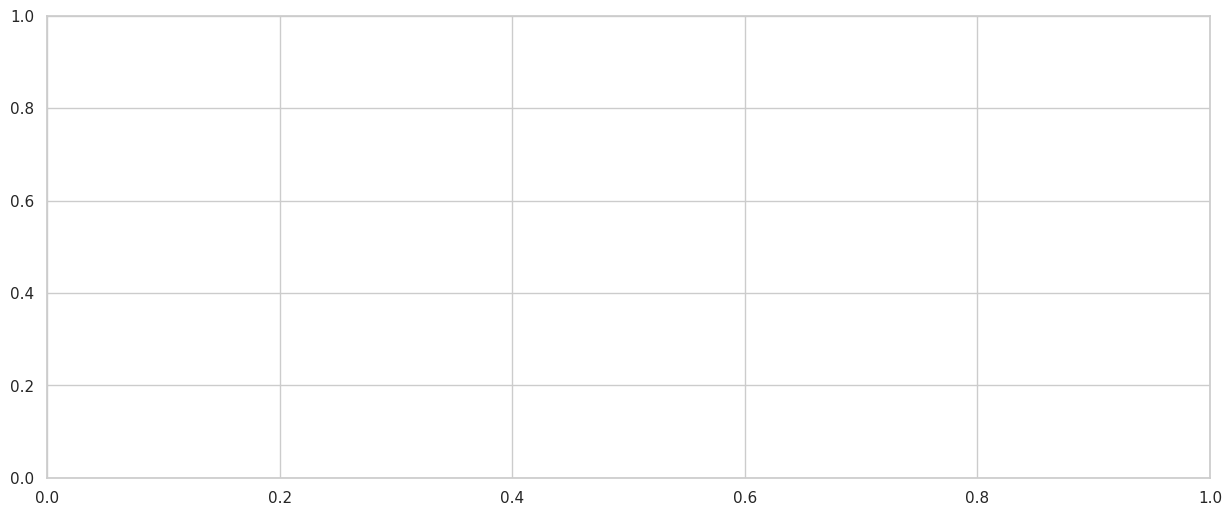

In [13]:
# Metrics graphs
print('SSD Metric comparative graph')
generate_hboxplot(SSD_all, Exp_names, 'SSD (au)', log=False, set_x_axis_size=(0, 100.1))
print('MAD Metric comparative graph')
generate_hboxplot(MAD_all, Exp_names, 'MAD (au)', log=False, set_x_axis_size=(0, 3.01))
print('PRD Metric comparative graph')
generate_hboxplot(PRD_all, Exp_names, 'PRD (au)', log=False, set_x_axis_size=(0, 150.1))
print('Cosine Similarity Metric comparative graph')
generate_hboxplot(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, set_x_axis_size=(0, 1))

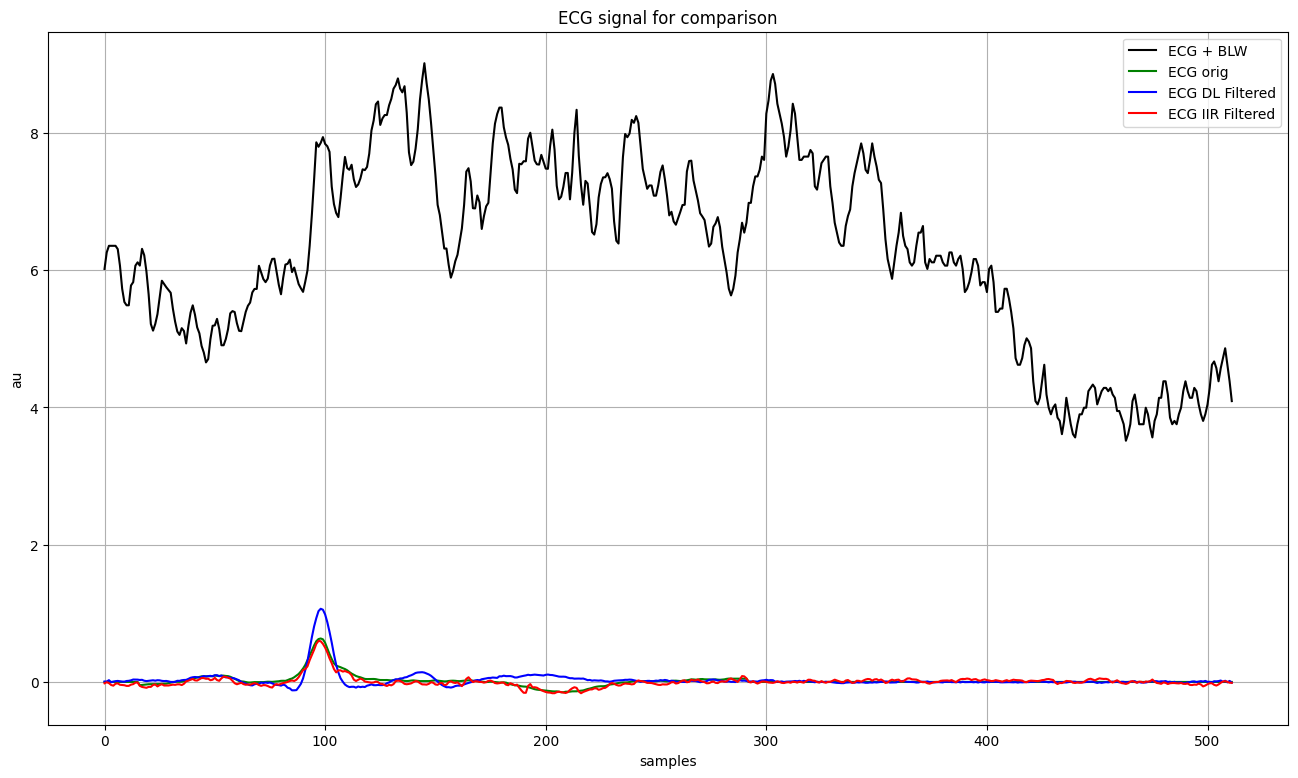

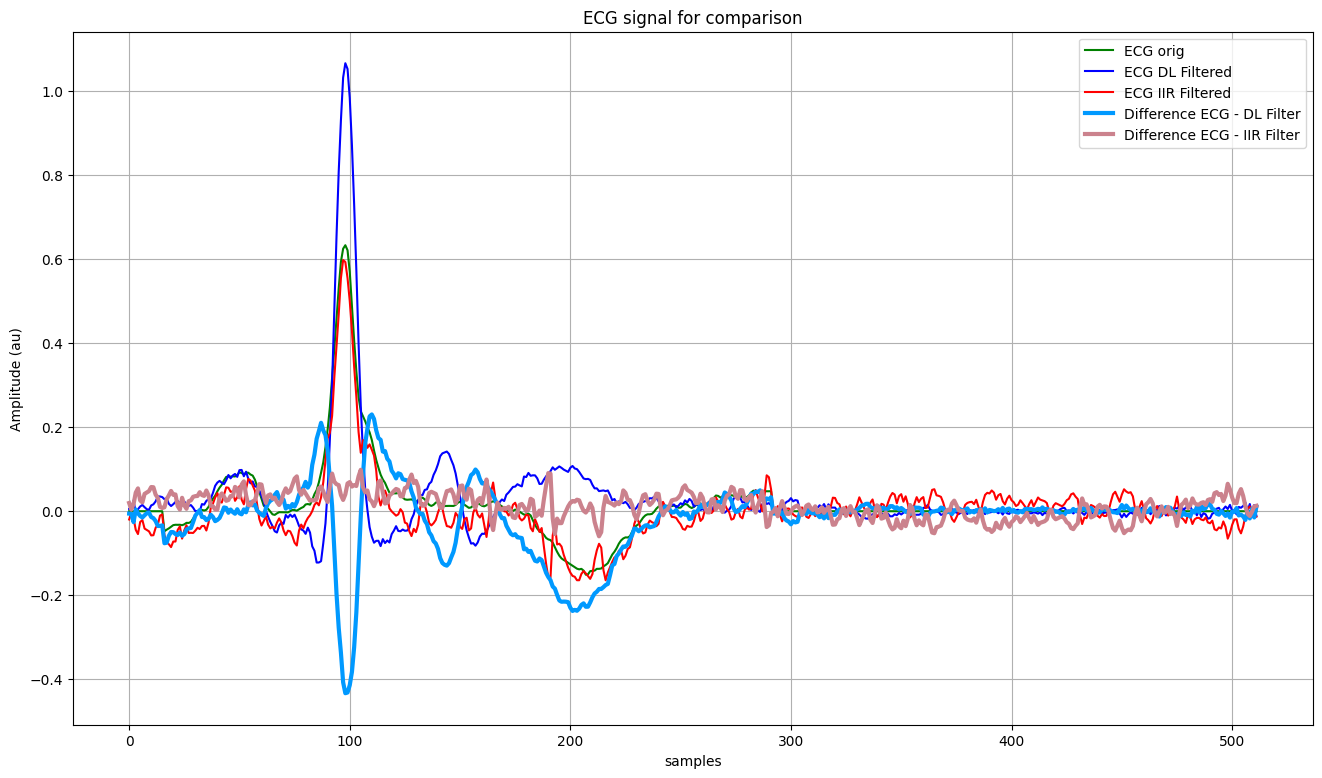

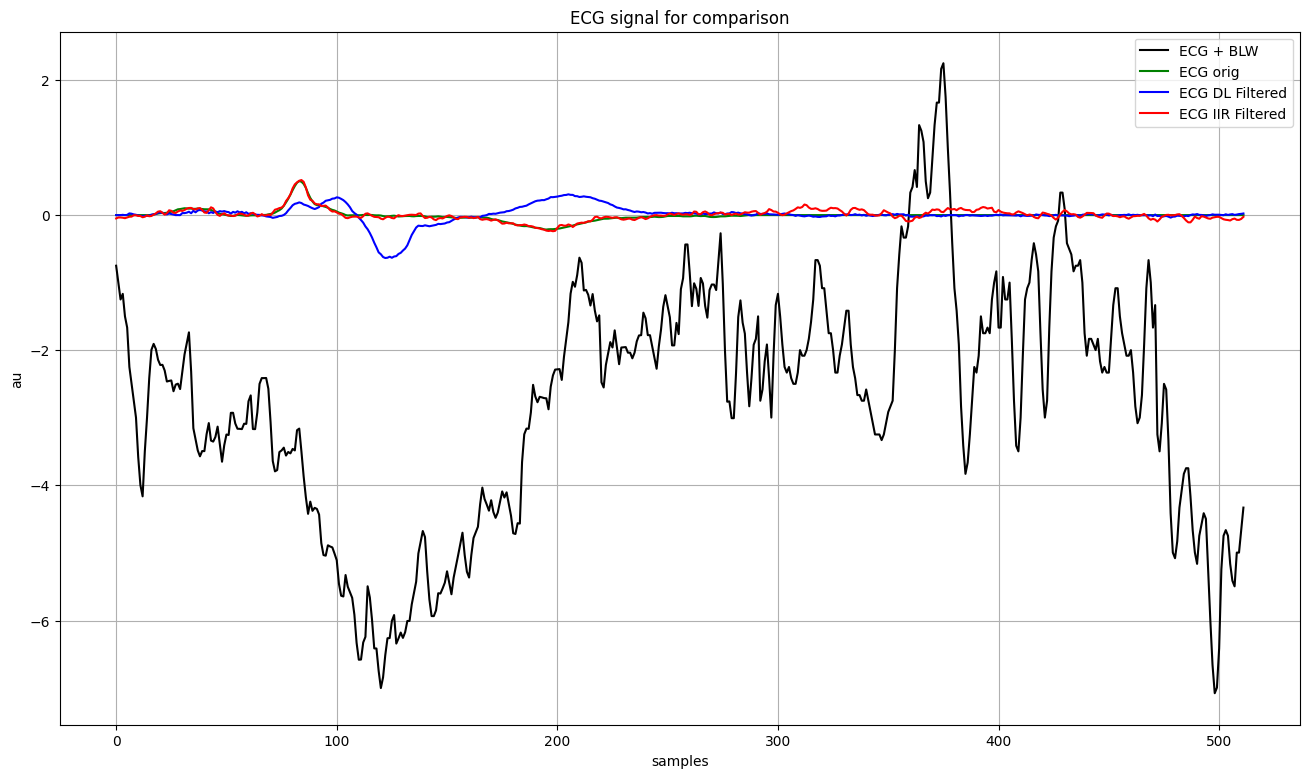

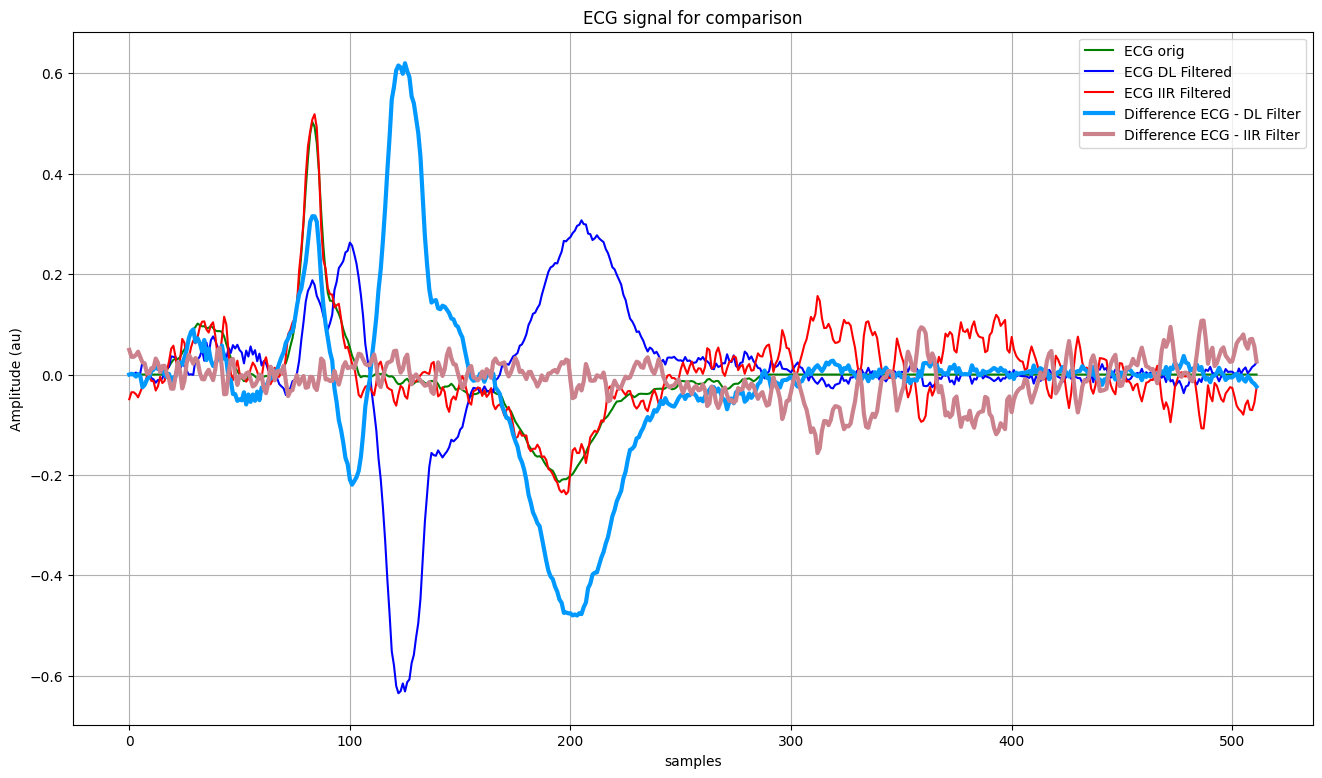

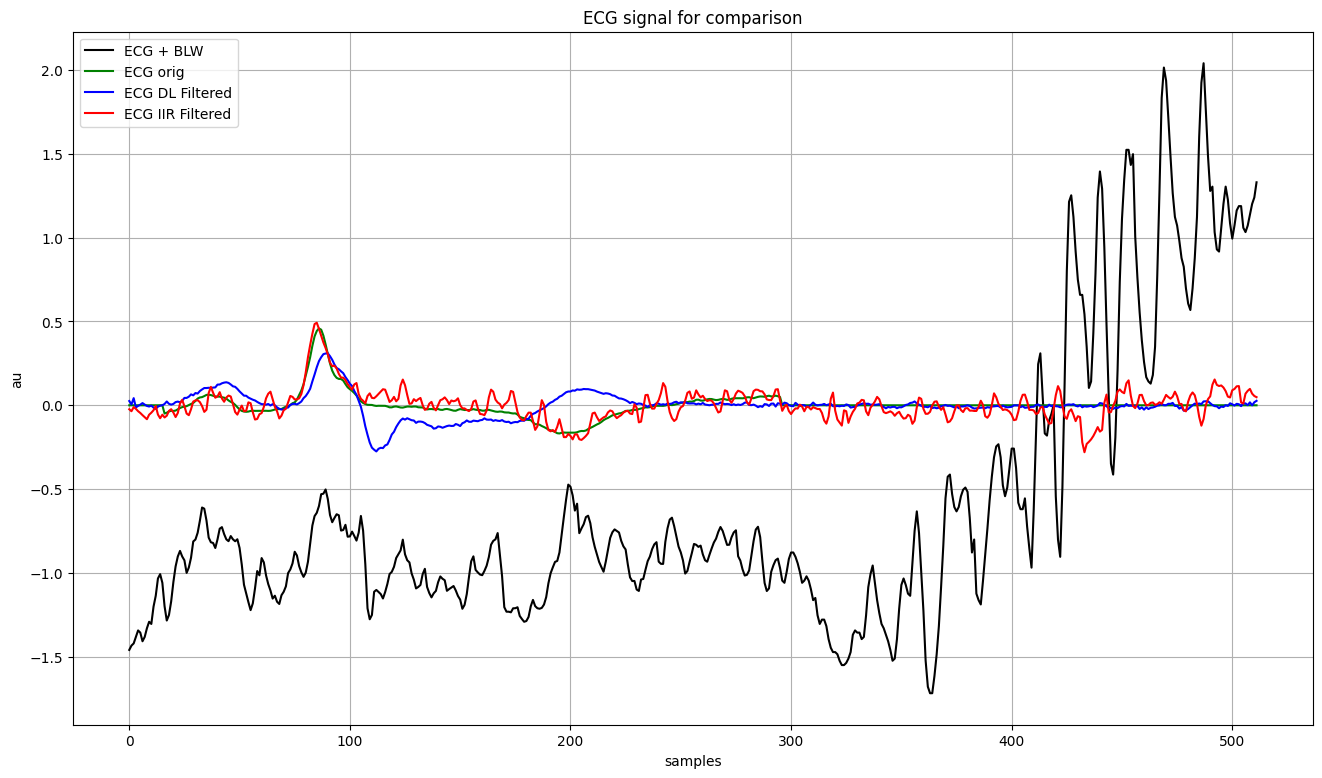

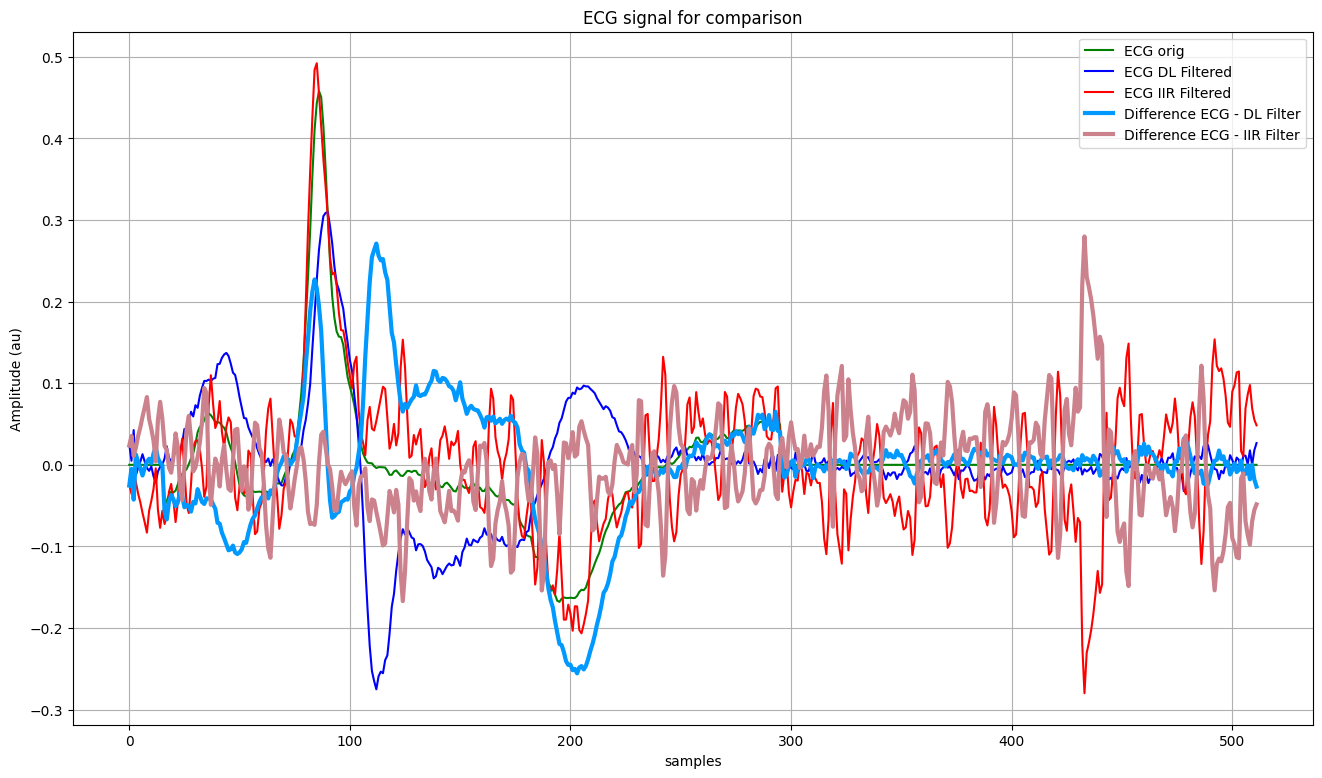

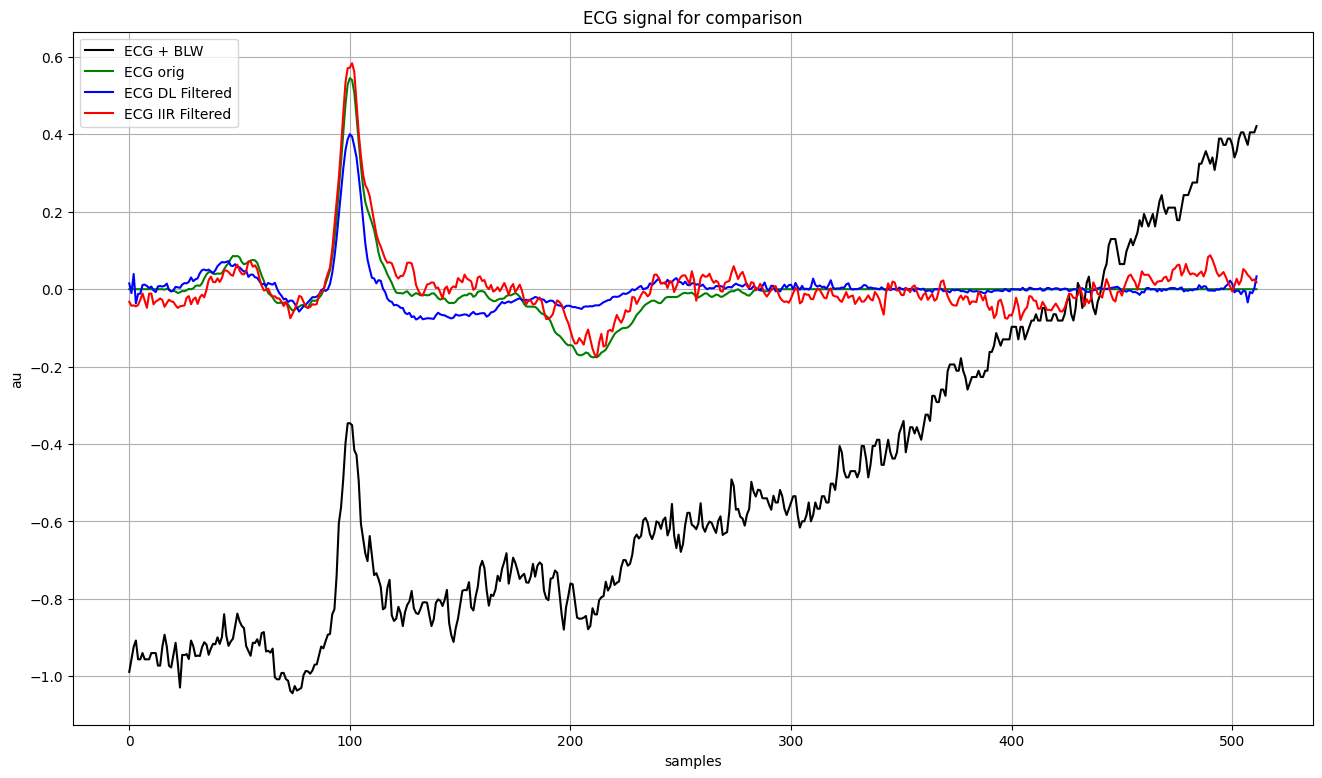

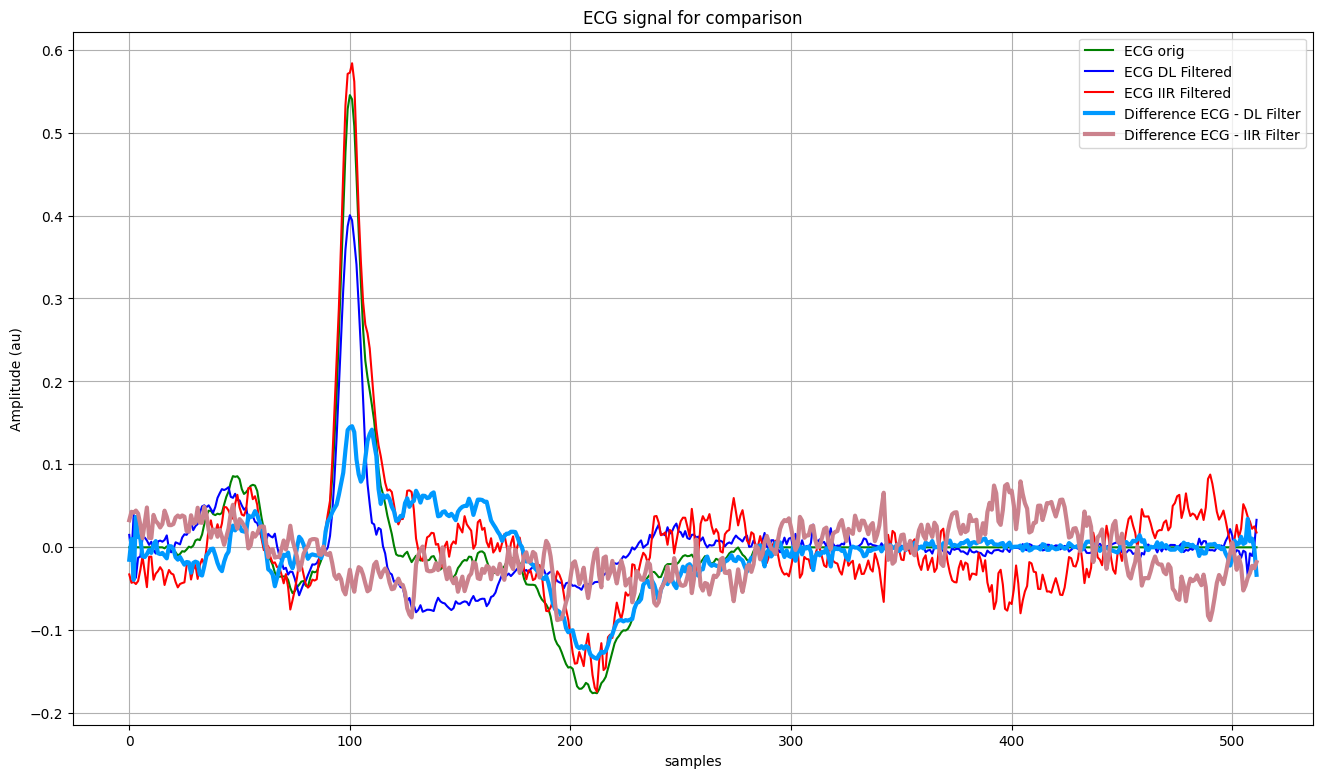

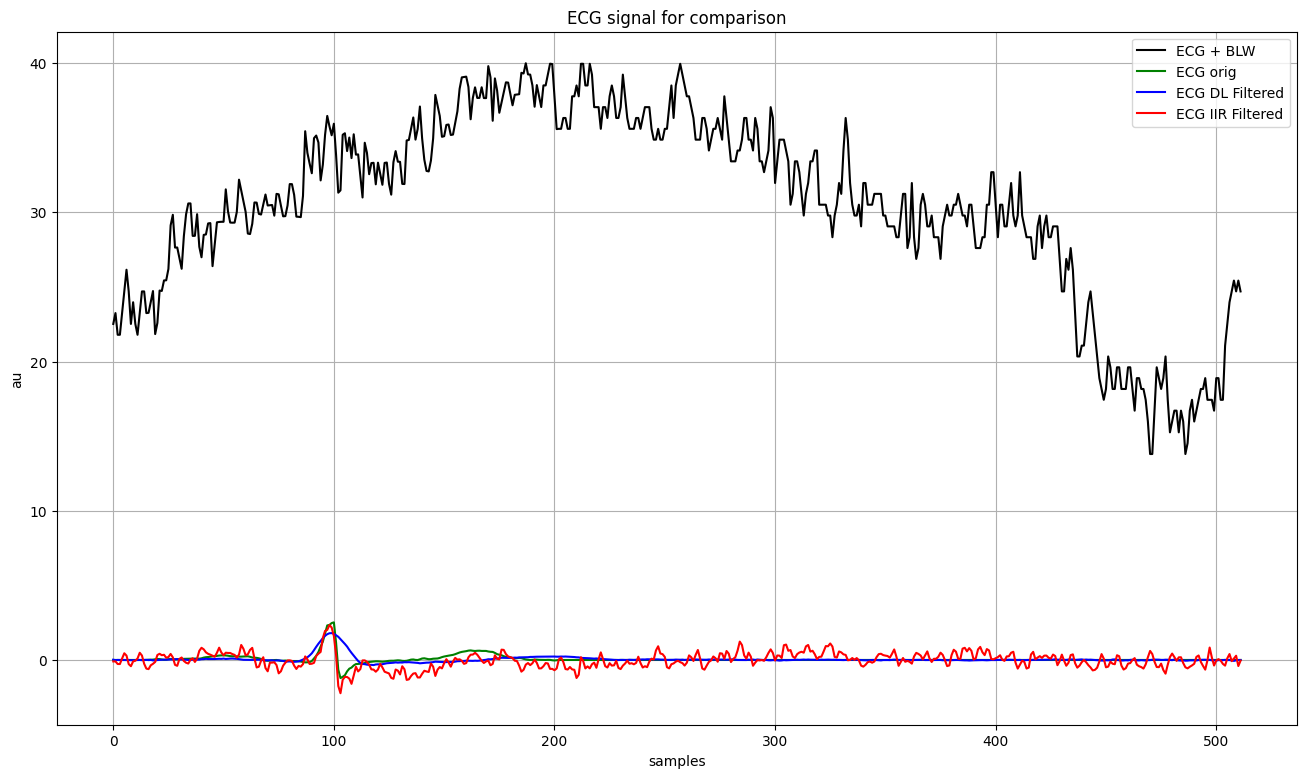

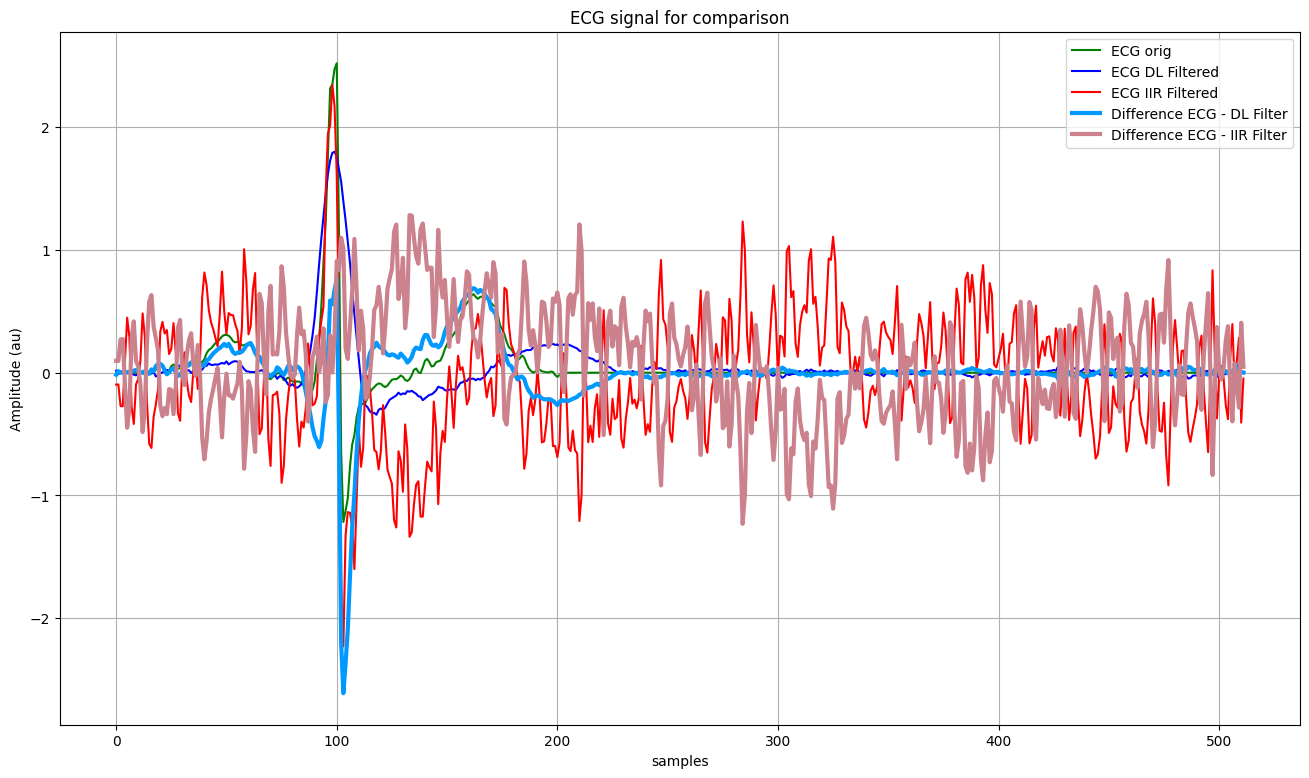

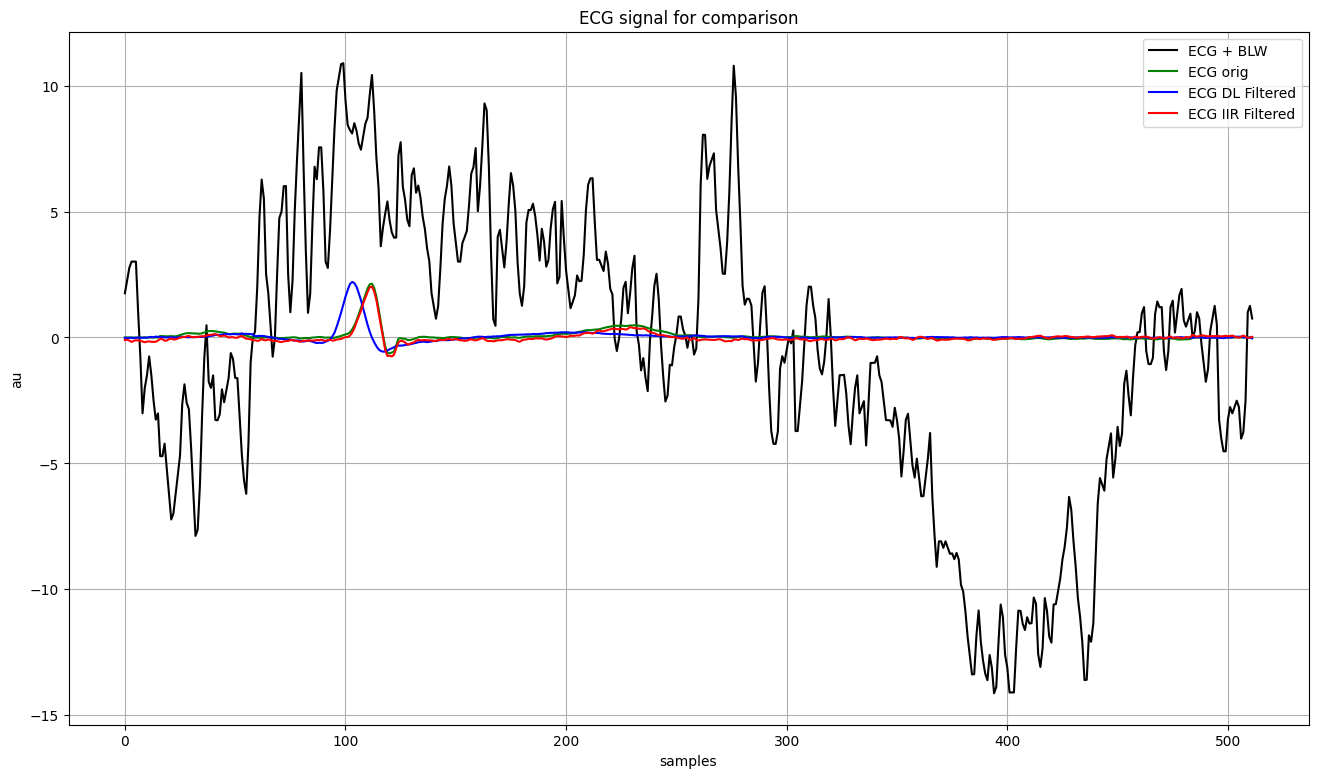

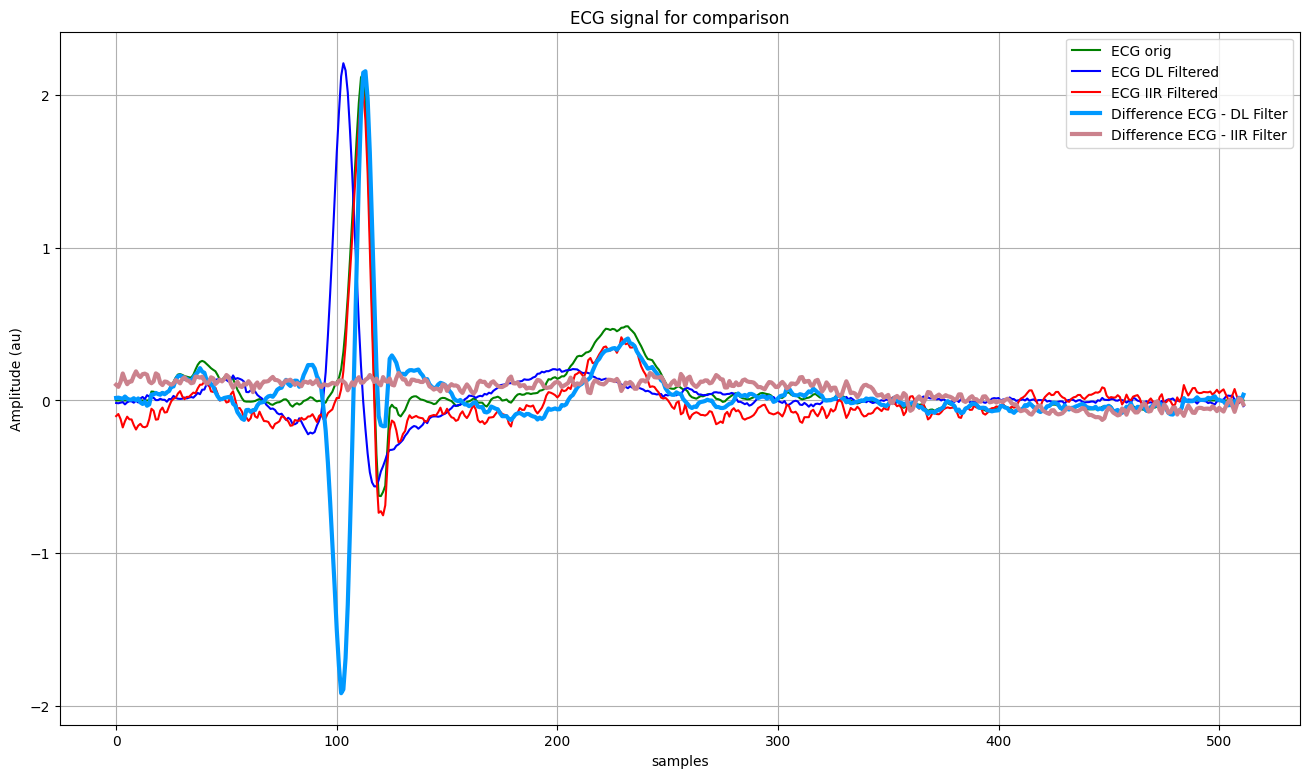

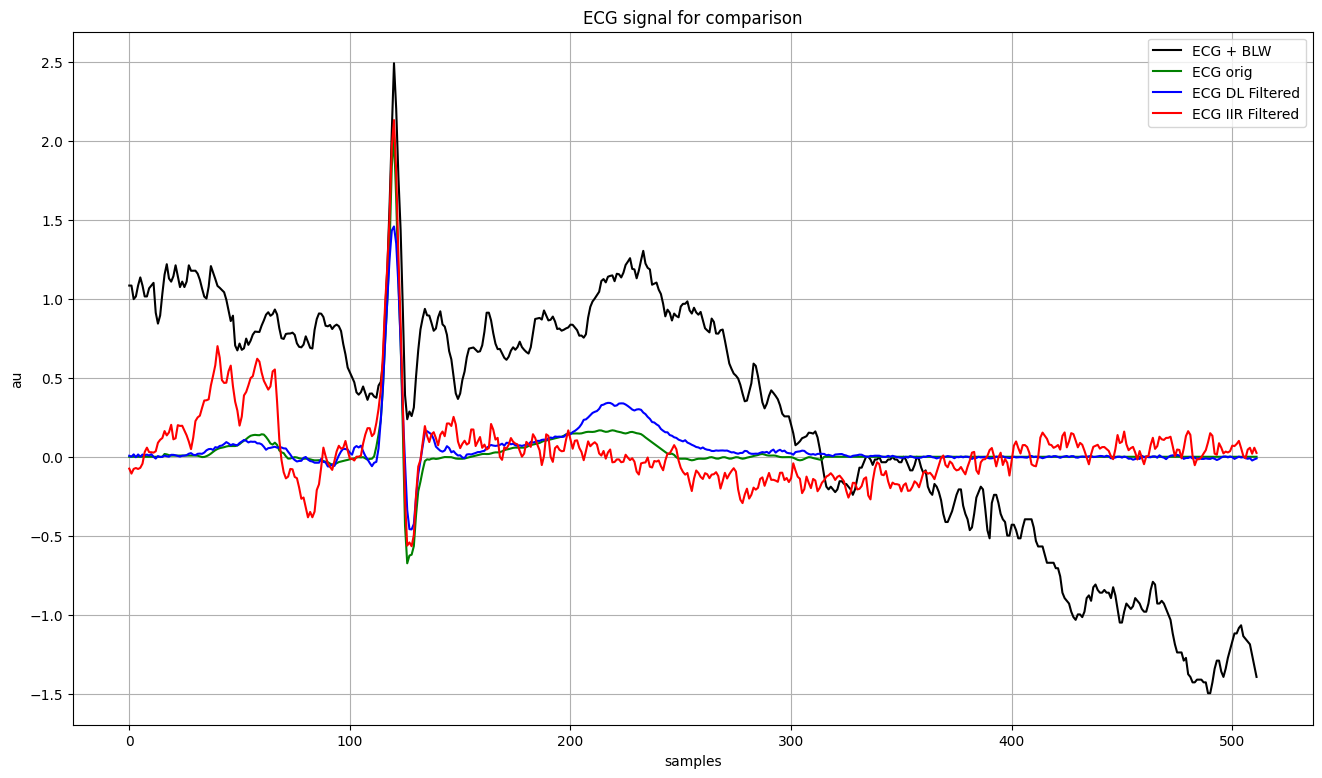

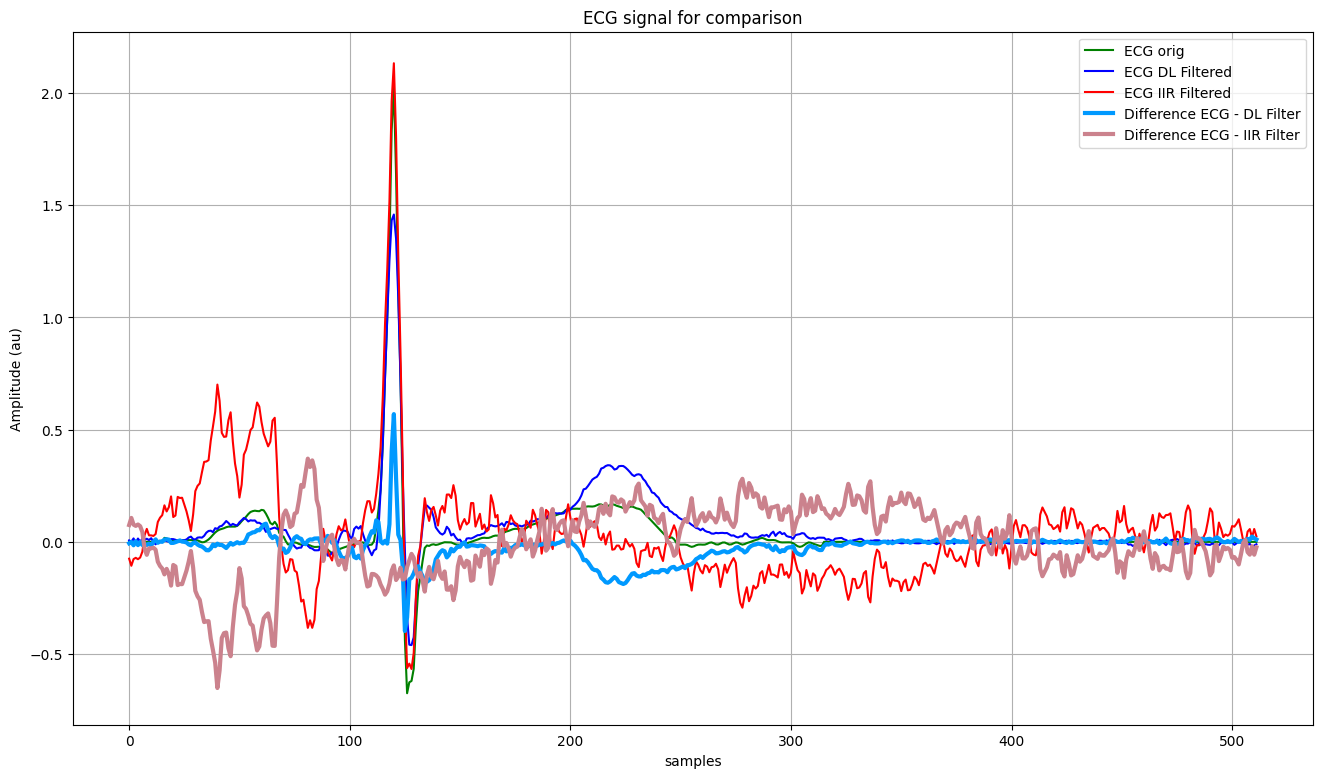

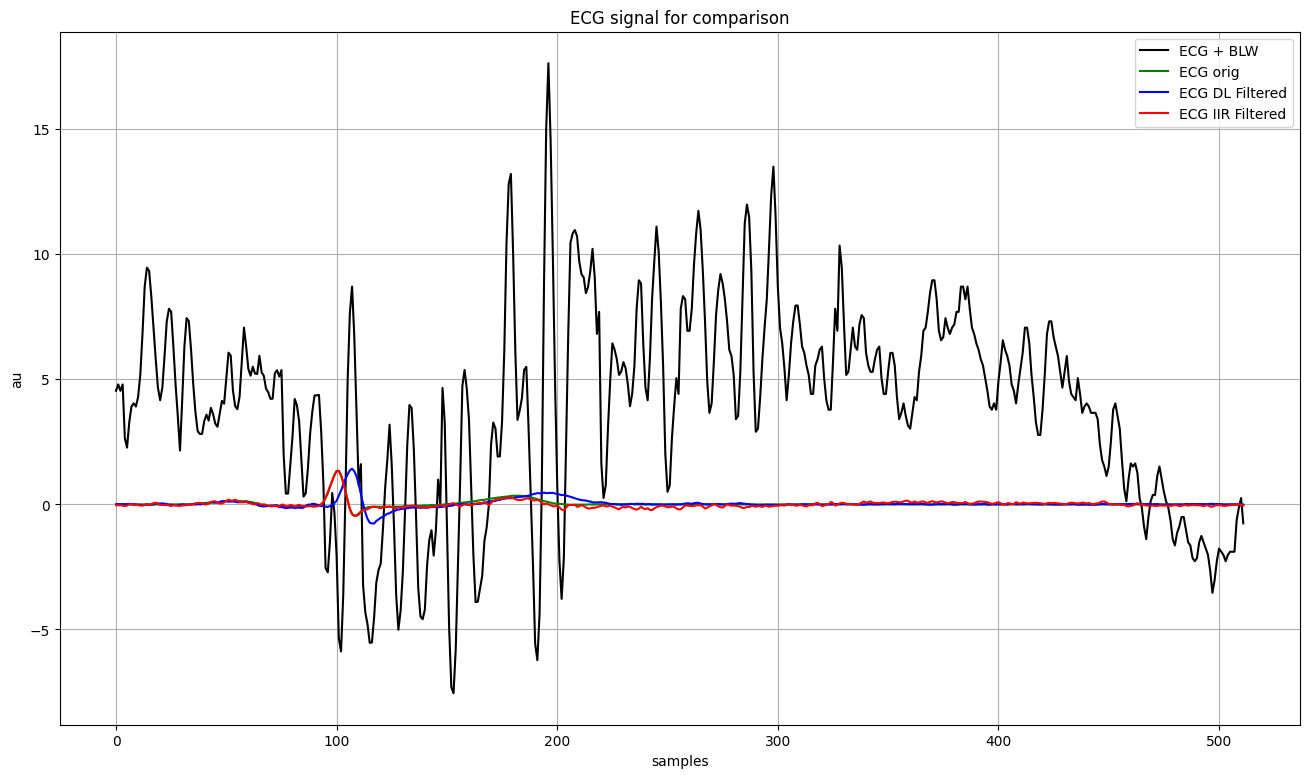

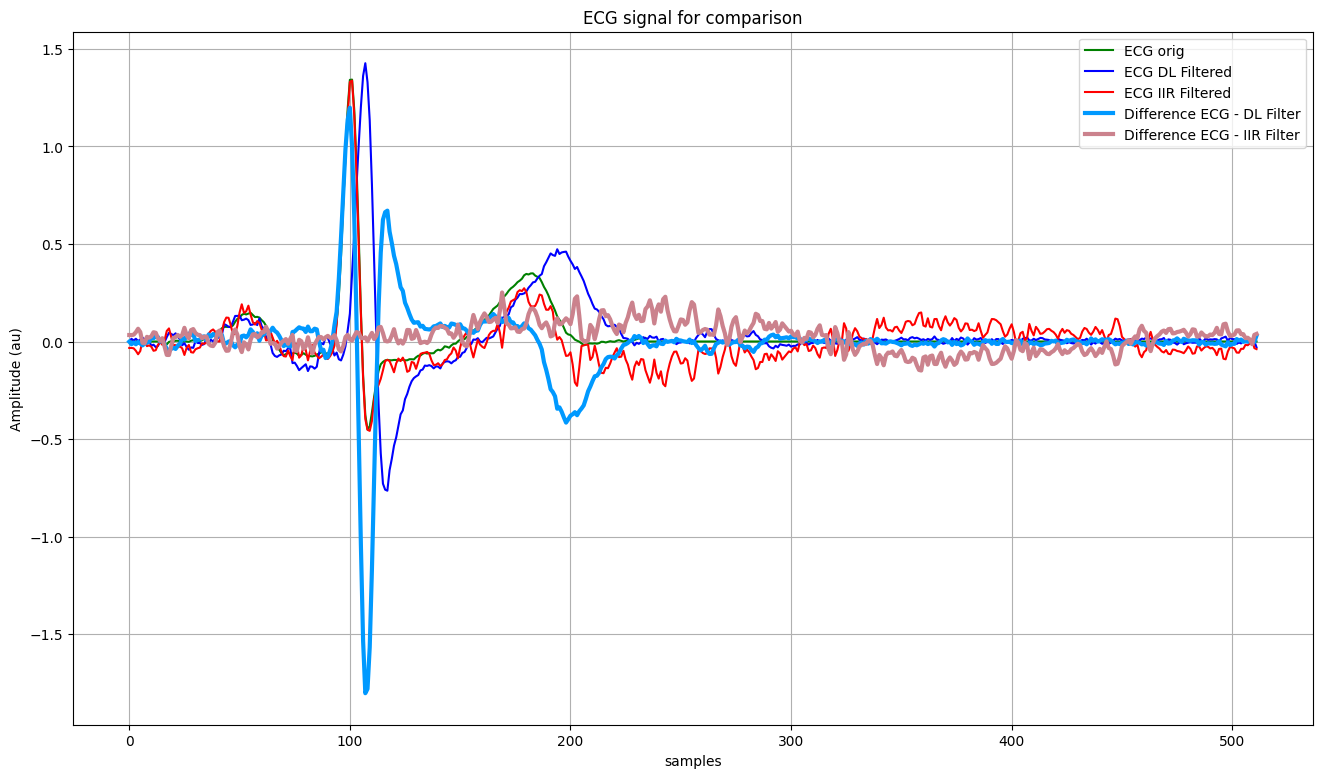

In [33]:
# Visualize signals

signals_index = np.array([110, 210, 410, 810, 1610, 3210, 6410, 12810]) + 10

ecg_signals2plot = []
ecgbl_signals2plot = []
dl_signals2plot = []
fil_signals2plot = []

signal_amount = 10

[X_test, y_test, y_pred] = test_Transformer_FDAE
for id in signals_index:
    ecgbl_signals2plot.append(X_test[id])
    ecg_signals2plot.append(y_test[id])
    dl_signals2plot.append(y_pred[id])

[X_test, y_test, y_filter] = test_IIR
for id in signals_index:
    fil_signals2plot.append(y_filter[id])

for i in range(len(signals_index)):
    ecg_view(ecg=ecg_signals2plot[i],
             ecg_blw=ecgbl_signals2plot[i],
             ecg_dl=dl_signals2plot[i],
             ecg_f=fil_signals2plot[i],
             signal_name=None,
             beat_no=None)

    ecg_view_diff(ecg=ecg_signals2plot[i],
                  ecg_blw=ecgbl_signals2plot[i],
                  ecg_dl=dl_signals2plot[i],
                  ecg_f=fil_signals2plot[i],
                  signal_name=None,
                  beat_no=None)

In [ ]:
while True:pass